In [1]:
%cd ../../../

/home/schilcherj/master/deepClustering/LMU_Master_Practical_SoSe24


/home/schilcherj/master/deepClustering/deepClustEnv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
%load_ext autoreload
%autoreload 2
from practical.DeepClustering.DipECT.dipect import Cluster_Tree, DipECT
from clustpy.deep._data_utils import get_dataloader
from clustpy.data.real_torchvision_data import load_mnist
from clustpy.deep.dipencoder import _Dip_Gradient, dip_test
from clustpy.deep.autoencoders import FeedforwardAutoencoder
import numpy as np
from sklearn.cluster import KMeans
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from clustpy.metrics import unsupervised_clustering_accuracy
import random
import umap
from sklearn.decomposition import PCA


/home/schilcherj/master/deepClustering/deepClustEnv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [157]:
def get_inital_projection_axis(X_embedd):
        """
        Returns the inital projection axis for the data in the given trainloader. Furthermore, the size of the higher projection cluster and the lower projection cluster will be returned (e.g to initialise pruning indicator).
        """
        # init projection axis on full dataset
        kmeans = KMeans(n_clusters=2, n_init=10).fit(X_embedd)
        kmeans_centers = kmeans.cluster_centers_
        labels = kmeans.labels_
        axis = kmeans_centers[0] - kmeans_centers[1]
        
        return axis, kmeans_centers[0], kmeans_centers[1]
def predict_subclusters(data, axis):
        projections = data @ axis
        sorted_indices = projections.argsort()
        dip_value, modal_interval, modal_triangle = dip_test(projections[sorted_indices], is_data_sorted=True, just_dip=False)
        index_lower, index_upper = modal_interval
        index_tri1, index_tri2, index_tri3 = modal_triangle
        if projections[sorted_indices[index_tri2]] > projections[sorted_indices[index_upper]]:
                treshhold =  (projections[sorted_indices[index_tri2]] + projections[sorted_indices[index_upper]])/2
        else:
                treshhold =  (projections[sorted_indices[index_tri2]] + projections[sorted_indices[index_lower]])/2
        labels = np.zeros(len(data))
        labels[projections >= treshhold] = 1
        labels[sorted_indices[index_tri2]] = 2
        labels[sorted_indices[index_lower]] = 3
        labels[sorted_indices[index_upper]] = 3
        return labels


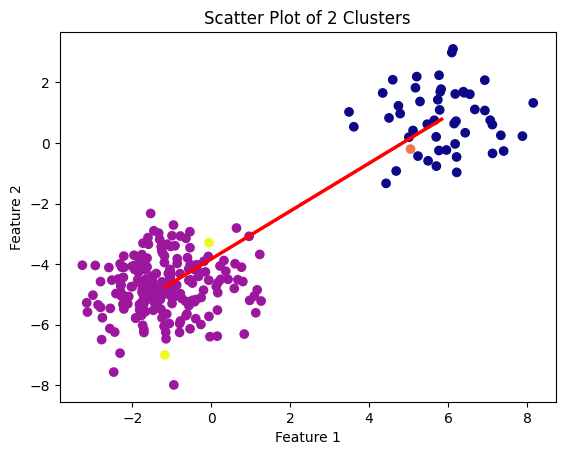

In [172]:


# Generate sample data
# X, y = make_blobs(n_samples=300, centers=2)
# Generate sample data with clusters of different sizes
X1, y1 = make_blobs(n_samples=50, centers=1,)
X2, y2 = make_blobs(n_samples=200, centers=1, )

# Combine the datasets
X = np.vstack((X1, X2))
y = np.hstack((y1, y2 + 1))  # Adjust labels for the second cluster

axis, c1, c2 = get_inital_projection_axis(X)

labels = predict_subclusters(X, axis)


# Create a scatter plot
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='plasma', marker='o')

# origin = [np.mean(X, axis=0)[0]], [np.mean(X, axis=0)[1]]  # Vector origin point
# plt.quiver(*origin, axis[0], axis[1], scale=5, color='red', label='Direction Vector')
plt.plot([c1[0], c2[0]], [c1[1], c2[1]], color='red',linewidth=2.5, label='Line between points')

# Add title and labels
plt.title('Scatter Plot of 2 Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Show plot
plt.show()

#assignments:  200
#assignments:  400
#assignments best node:  400
True
1.0


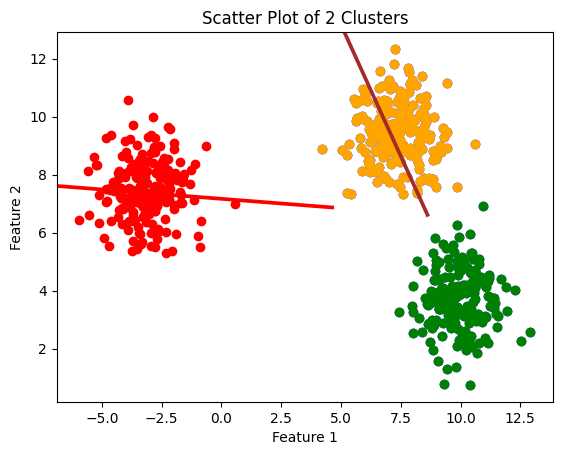

In [116]:
# Generate sample data
X, y = make_blobs(n_samples=600, centers=3)

# X1, y1 = make_blobs(n_samples=50, centers=1)
# X2, y2 = make_blobs(n_samples=200, centers=1)
# X3, y3 = make_blobs(n_samples=100, centers=1)
# X4, y4 = make_blobs(n_samples=250, centers=1)

# Combine the datasets
# X = np.vstack((X1, X2, X3, X4))
# y = np.hstack((y1, y2 + 1, y3 + 2, y4 + 3))  

dataloader = get_dataloader(X, 50 )
encode = lambda x: x
autoencoder = type("Autoencoder", (), {"encode": encode})

tree = Cluster_Tree(dataloader, autoencoder, None, "cpu", max_leaf_nodes=10)

tree.assign_to_tree(torch.from_numpy(X))

# Create a scatter plot
plt.scatter(tree.root.lower_projection_child.assignments[:, 0], tree.root.lower_projection_child.assignments[:, 1], c="blue", marker='o')
plt.scatter(tree.root.higher_projection_child.assignments[:, 0], tree.root.higher_projection_child.assignments[:, 1], c="red", marker='o')

origin = [np.mean(X, axis=0)[0]], [np.mean(X, axis=0)[1]]  # Vector origin point
plt.quiver(*origin, tree.root.projection_axis.data[0], tree.root.projection_axis.data[1], scale=5, color='red', label='Direction Vector')

# Add title and labels
plt.title('Scatter Plot of 2 Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Show plot


tree.grow_tree(dataloader, autoencoder, None, 0.0)
tree.assign_to_tree(torch.from_numpy(X))

pred_labels = np.ones(len(X))*-1

if tree.root.lower_projection_child.is_leaf_node():
    plt.scatter(tree.root.higher_projection_child.lower_projection_child.assignments[:, 0],tree.root.higher_projection_child.lower_projection_child.assignments[:, 1], c="green", marker='o')
    plt.scatter(tree.root.higher_projection_child.higher_projection_child.assignments[:, 0], tree.root.higher_projection_child.higher_projection_child.assignments[:, 1], c="orange", marker='o')

    origin = [np.mean(tree.root.higher_projection_child.assignments.numpy(), axis=0)[0]], [np.mean(tree.root.higher_projection_child.assignments.numpy(), axis=0)[1]]  # Vector origin point
    plt.quiver(*origin, tree.root.higher_projection_child.projection_axis.data[0], tree.root.higher_projection_child.projection_axis.data[1], scale=5, color='brown', label='Direction Vector')
    X_combined = torch.cat((tree.root.higher_projection_child.lower_projection_child.assignments, tree.root.higher_projection_child.higher_projection_child.assignments), dim=0)
    
    X_combined_sorted, _ = torch.sort(X_combined, dim=0)
    X_sorted, _ = torch.sort(tree.root.higher_projection_child.assignments, dim=0)

    # Check if the sorted tensors are identical
    is_identical = torch.equal(X_sorted, X_combined_sorted)
    print(is_identical)
    pred_labels[tree.root.higher_projection_child.lower_projection_child.assignment_indices] = 0
    pred_labels[tree.root.higher_projection_child.higher_projection_child.assignment_indices] = 1
    pred_labels[tree.root.lower_projection_child.assignment_indices] = 2
else:
    plt.scatter(tree.root.lower_projection_child.lower_projection_child.assignments[:, 0],tree.root.lower_projection_child.lower_projection_child.assignments[:, 1], c="green", marker='o')
    plt.scatter(tree.root.lower_projection_child.higher_projection_child.assignments[:, 0], tree.root.lower_projection_child.higher_projection_child.assignments[:, 1], c="orange", marker='o')
    origin = [np.mean(tree.root.lower_projection_child.assignments.numpy(), axis=0)[0]], [np.mean(tree.root.lower_projection_child.assignments.numpy(), axis=0)[1]]  # Vector origin point
    plt.quiver(*origin, tree.root.lower_projection_child.projection_axis.data[0], tree.root.lower_projection_child.projection_axis.data[1], scale=5, color='brown', label='Direction Vector')

    X_combined = torch.cat((tree.root.lower_projection_child.lower_projection_child.assignments, tree.root.lower_projection_child.higher_projection_child.assignments), dim=0)

    X_combined_sorted, _ = torch.sort(X_combined, dim=0)
    X_sorted, _ = torch.sort(tree.root.lower_projection_child.assignments, dim=0)

    # Check if the sorted tensors are identical
    is_identical = torch.equal(X_sorted, X_combined_sorted)
    print(is_identical)
    pred_labels[tree.root.lower_projection_child.lower_projection_child.assignment_indices] = 0
    pred_labels[tree.root.lower_projection_child.higher_projection_child.assignment_indices] = 1
    pred_labels[tree.root.higher_projection_child.assignment_indices] = 2

print(unsupervised_clustering_accuracy(y, pred_labels))
plt.show()


In [11]:
data = load_mnist()["data"]
encode = lambda x: x
autoencoder = type("Autoencoder", (), {"encode": encode})

tree = Cluster_Tree(dataloader, autoencoder, None, "cpu")

In [17]:
dataset, labels = load_mnist(return_X_y=True)
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/pretrained_AE.pth"))
autoencoder.fitted = True

dipect = DipECT(autoencoder=autoencoder, grow_interval=1500, max_iterations=15000) # wenn batch_size=len(dataset), cluster loss fällt monoton
dipect = dipect.fit_predict(dataset)

cpu


Fit:   0%|          | 5/15000 [00:00<16:22, 15.27it/s]

1.9281936287879944
-0.032504476606845856
1.4340778291225433
-0.032222453504800797
1.267698884010315
-0.06060679629445076
1.186832070350647
-0.03990325331687927


Fit:   0%|          | 9/15000 [00:00<14:11, 17.60it/s]

1.13365695476532
-0.05050213634967804
1.1036821007728577
-0.045321106910705566
1.0782186899866377
-0.04428927227854729
1.0611125826835632
-0.04422934725880623


Fit:   0%|          | 11/15000 [00:00<14:38, 17.07it/s]

1.0513165328237746
-0.05311746150255203
1.0433346033096313
-0.03236479312181473


Fit:   1%|          | 104/15000 [00:05<11:18, 21.95it/s]

0.9041272318363189
-0.06828524172306061


Fit:   1%|▏         | 203/15000 [00:09<11:18, 21.81it/s]

0.8756234452128411
-0.08585697412490845


Fit:   2%|▏         | 303/15000 [00:14<13:33, 18.07it/s]

0.8531234240531922
-0.14974623918533325


Fit:   3%|▎         | 404/15000 [00:20<13:34, 17.92it/s]

0.8353412410616875
-0.13673853874206543


Fit:   3%|▎         | 504/15000 [00:26<12:54, 18.71it/s]

0.8224585638046265
-0.17044654488563538


Fit:   4%|▍         | 603/15000 [00:31<13:28, 17.82it/s]

0.8091090401013692
-0.19958026707172394


Fit:   5%|▍         | 703/15000 [00:37<13:04, 18.23it/s]

0.7986897448131016
-0.21842850744724274


Fit:   5%|▌         | 801/15000 [00:49<18:59, 12.46it/s]  

0.788894512206316
-0.20575106143951416


Fit:   6%|▌         | 901/15000 [00:57<18:44, 12.53it/s]

0.7803069028589461
-0.23025061190128326


Fit:   7%|▋         | 1003/15000 [01:05<17:38, 13.23it/s]

0.7729723434448242
-0.24045708775520325


Fit:   7%|▋         | 1102/15000 [01:14<18:30, 12.52it/s]

0.765963837666945
-0.22897976636886597


Fit:   8%|▊         | 1202/15000 [01:22<20:22, 11.28it/s]

0.7598841544985772
-0.21840693056583405


Fit:   9%|▊         | 1301/15000 [01:33<30:09,  7.57it/s]

0.7541819237287228
-0.2540425658226013


Fit:   9%|▉         | 1402/15000 [01:44<26:50,  8.44it/s]

0.7491620415023394
-0.2315158098936081


Fit:  10%|█         | 1501/15000 [02:07<10:32:40,  2.81s/it]

0.7442367253303528
-0.4198419749736786


Fit:  11%|█         | 1602/15000 [02:18<24:59,  8.93it/s]   

0.7256873995065689
-0.47961142659187317


Fit:  11%|█▏        | 1702/15000 [02:30<26:58,  8.22it/s]

0.707602918603841
-0.5677955150604248


Fit:  12%|█▏        | 1802/15000 [02:43<23:55,  9.19it/s]

0.6898094874454869
-0.5891277194023132


Fit:  13%|█▎        | 1901/15000 [02:55<23:19,  9.36it/s]

0.6728727467907103
-0.6070169806480408


Fit:  13%|█▎        | 2002/15000 [03:07<27:01,  8.02it/s]

0.6564537867456675
-0.5764117240905762


Fit:  14%|█▍        | 2101/15000 [03:17<18:42, 11.49it/s]

0.6417182633280754
-0.5597299933433533


Fit:  15%|█▍        | 2201/15000 [03:26<18:05, 11.79it/s]

0.6275553344731981
-0.6051796674728394


Fit:  15%|█▌        | 2302/15000 [03:36<25:52,  8.18it/s]

0.6137459743670796
-0.6784868836402893


Fit:  16%|█▌        | 2402/15000 [03:49<27:48,  7.55it/s]

0.6013620868201057
-0.6716014742851257


Fit:  17%|█▋        | 2501/15000 [04:00<36:10,  5.76it/s]

0.5893065861821175
-0.6164255738258362


Fit:  17%|█▋        | 2602/15000 [04:12<19:20, 10.69it/s]

0.5776605545213589
-0.6705899238586426


Fit:  18%|█▊        | 2702/15000 [04:23<20:45,  9.87it/s]

0.5665195756377998
-0.5523108243942261


Fit:  19%|█▊        | 2802/15000 [04:35<22:38,  8.98it/s]

0.5564074138977698
-0.652107834815979


Fit:  19%|█▉        | 2903/15000 [04:44<16:00, 12.60it/s]

0.546277407150844
-0.6520865559577942


Fit:  20%|██        | 3002/15000 [04:57<2:44:12,  1.22it/s]

0.5367420621017615
-0.8975486755371094


Fit:  21%|██        | 3102/15000 [05:04<13:52, 14.29it/s]  

0.5158023642820697
-1.131860375404358


Fit:  21%|██▏       | 3202/15000 [05:11<13:21, 14.72it/s]

0.49536004637368025
-1.1436887979507446


Fit:  22%|██▏       | 3302/15000 [05:18<13:25, 14.53it/s]

0.4754203155275547
-1.2011877298355103


Fit:  23%|██▎       | 3402/15000 [05:25<13:34, 14.24it/s]

0.45587204884956867
-1.1669533252716064


Fit:  23%|██▎       | 3502/15000 [05:32<13:58, 13.71it/s]

0.4377740403498922
-1.0026836395263672


Fit:  24%|██▍       | 3602/15000 [05:39<13:12, 14.38it/s]

0.4201325992163685
-1.1513360738754272


Fit:  25%|██▍       | 3702/15000 [05:46<12:46, 14.75it/s]

0.4032031407630121
-1.1952476501464844


Fit:  25%|██▌       | 3802/15000 [05:52<12:31, 14.90it/s]

0.3864920853705783
-1.0996274948120117


Fit:  26%|██▌       | 3902/15000 [05:59<12:49, 14.42it/s]

0.37056182952263417
-1.1030434370040894


Fit:  27%|██▋       | 4002/15000 [06:06<12:42, 14.43it/s]

0.35509703289717437
-1.2324621677398682


Fit:  27%|██▋       | 4102/15000 [06:13<12:24, 14.64it/s]

0.34030598277725826
-1.1487462520599365


Fit:  28%|██▊       | 4202/15000 [06:20<11:37, 15.48it/s]

0.3262644430072535
-1.1359509229660034


Fit:  29%|██▊       | 4302/15000 [06:27<14:05, 12.65it/s]

0.312489910839602
-1.1649589538574219


Fit:  29%|██▉       | 4402/15000 [06:34<14:54, 11.85it/s]

0.2992398541420698
-1.2952715158462524


Fit:  30%|███       | 4502/15000 [06:50<3:06:47,  1.07s/it]

0.2864519557621744
-1.8092683553695679


Fit:  31%|███       | 4602/15000 [06:57<13:01, 13.31it/s]  

0.2620269715462042
-1.8504118919372559


Fit:  31%|███▏      | 4702/15000 [07:04<12:09, 14.11it/s]

0.23776339832138507
-1.7746763229370117


Fit:  32%|███▏      | 4801/15000 [07:15<33:54,  5.01it/s]

0.21378155019755166
-1.8214091062545776


Fit:  33%|███▎      | 4902/15000 [07:27<18:29,  9.10it/s]

0.18991849104360659
-1.8942011594772339


Fit:  33%|███▎      | 5002/15000 [07:38<15:07, 11.02it/s]

0.16663893830180168
-2.0586323738098145


Fit:  34%|███▍      | 5101/15000 [07:48<15:02, 10.97it/s]

0.14389412400184892
-2.0963263511657715


Fit:  35%|███▍      | 5201/15000 [07:59<15:56, 10.25it/s]

0.12204856587717167
-2.068028450012207


Fit:  35%|███▌      | 5302/15000 [08:09<16:06, 10.04it/s]

0.10073586874975349
-2.0584893226623535


Fit:  36%|███▌      | 5402/15000 [08:20<19:28,  8.22it/s]

0.07995390040455042
-2.20465087890625


Fit:  37%|███▋      | 5501/15000 [08:31<20:29,  7.72it/s]

0.05991447404839776
-1.9173732995986938


Fit:  37%|███▋      | 5602/15000 [08:43<18:07,  8.65it/s]

0.04033134515264204
-2.040163516998291


Fit:  38%|███▊      | 5701/15000 [08:54<14:15, 10.87it/s]

0.02110176310727471
-1.9082574844360352


Fit:  39%|███▊      | 5802/15000 [09:04<14:30, 10.57it/s]

0.002481226772069931
-1.9382014274597168


Fit:  39%|███▉      | 5903/15000 [09:14<11:36, 13.06it/s]

-0.015613071852821415
-2.009679079055786


Fit:  40%|████      | 6001/15000 [09:32<4:02:41,  1.62s/it]

-0.03369686501721541
-2.271754264831543


Fit:  41%|████      | 6102/15000 [09:43<17:32,  8.46it/s]  

-0.05543630767552579
-2.324673652648926


Fit:  41%|████▏     | 6202/15000 [09:55<16:45,  8.75it/s]

-0.07762872226295933
-2.3734521865844727


Fit:  42%|████▏     | 6301/15000 [10:07<22:38,  6.40it/s]

-0.09941615749446173
-2.293684959411621


Fit:  43%|████▎     | 6402/15000 [10:18<13:20, 10.74it/s]

-0.12116696476470679
-2.399106502532959


Fit:  43%|████▎     | 6502/15000 [10:29<17:23,  8.14it/s]

-0.14171275486854407
-2.3362956047058105


Fit:  44%|████▍     | 6601/15000 [10:40<14:01,  9.98it/s]

-0.16173933536265836
-2.256795883178711


Fit:  45%|████▍     | 6701/15000 [10:51<20:02,  6.90it/s]

-0.1819230806783064
-2.443119525909424


Fit:  45%|████▌     | 6801/15000 [11:04<14:13,  9.61it/s]

-0.20118386916816233
-2.3295204639434814


Fit:  46%|████▌     | 6901/15000 [11:14<16:44,  8.07it/s]

-0.22036966461634291
-2.654188632965088


Fit:  47%|████▋     | 7001/15000 [11:24<13:56,  9.56it/s]

-0.23896012482898576
-2.57004451751709


Fit:  47%|████▋     | 7102/15000 [11:35<12:10, 10.81it/s]

-0.2569063765188338
-2.3430330753326416


Fit:  48%|████▊     | 7201/15000 [11:47<18:11,  7.15it/s]

-0.2748775118548009
-2.446927309036255


Fit:  49%|████▊     | 7302/15000 [11:58<15:56,  8.05it/s]

-0.292181107683541
-2.487736225128174


Fit:  49%|████▉     | 7402/15000 [12:09<15:55,  7.95it/s]

-0.30919153290423185
-2.7000908851623535


Fit:  50%|█████     | 7502/15000 [12:30<3:10:47,  1.53s/it]

-0.32567665517727534
-2.725813388824463


Fit:  51%|█████     | 7601/15000 [12:42<11:55, 10.34it/s]  

-0.3475648357640756
-2.957007646560669


Fit:  51%|█████▏    | 7701/15000 [12:53<16:36,  7.32it/s]

-0.36877238376961124
-3.1544089317321777


Fit:  52%|█████▏    | 7802/15000 [13:05<13:28,  8.90it/s]

-0.3895668135354152
-2.7883148193359375


Fit:  53%|█████▎    | 7902/15000 [13:16<12:45,  9.27it/s]

-0.4102191638607013
-3.076754331588745


Fit:  53%|█████▎    | 8001/15000 [13:27<15:46,  7.39it/s]

-0.4308905121050775
-2.866865634918213


Fit:  54%|█████▍    | 8102/15000 [13:38<12:27,  9.23it/s]

-0.451433866241096
-3.0241646766662598


Fit:  55%|█████▍    | 8201/15000 [13:47<11:19, 10.00it/s]

-0.4710951838369777
-3.0074453353881836


Fit:  55%|█████▌    | 8301/15000 [13:57<10:27, 10.67it/s]

-0.49073841654751676
-3.2620811462402344


Fit:  56%|█████▌    | 8402/15000 [14:07<14:44,  7.46it/s]

-0.5097607641383296
-3.1409101486206055


Fit:  57%|█████▋    | 8500/15000 [14:17<09:32, 11.36it/s]

-0.5286883914575857
-3.3132996559143066


Fit:  57%|█████▋    | 8602/15000 [14:26<09:24, 11.33it/s]

-0.5470882325359555
-3.2830944061279297


Fit:  58%|█████▊    | 8702/15000 [14:37<09:27, 11.10it/s]

-0.5653526810222659
-3.114482879638672


Fit:  59%|█████▊    | 8802/15000 [14:45<08:10, 12.64it/s]

-0.5831875011291017
-3.2016944885253906


Fit:  59%|█████▉    | 8902/15000 [14:54<09:01, 11.25it/s]

-0.6008572439765663
-3.3065848350524902


Fit:  60%|██████    | 9002/15000 [15:12<2:32:55,  1.53s/it]

-0.6179935324158934
-3.5874571800231934


Fit:  61%|██████    | 9101/15000 [15:23<09:30, 10.34it/s]  

-0.6415288680169609
-3.7553606033325195


Fit:  61%|██████▏   | 9202/15000 [15:38<11:02,  8.75it/s]

-0.6651860405537098
-3.792776346206665


Fit:  62%|██████▏   | 9301/15000 [15:52<15:40,  6.06it/s]

-0.6886461262517078
-4.167421340942383


Fit:  63%|██████▎   | 9402/15000 [16:04<08:48, 10.59it/s]

-0.7118729614165235
-3.69305419921875


Fit:  63%|██████▎   | 9501/15000 [16:16<08:07, 11.28it/s]

-0.7349187875515536
-3.65891170501709


Fit:  64%|██████▍   | 9602/15000 [16:25<08:26, 10.66it/s]

-0.7574289328822246
-3.883293628692627


Fit:  65%|██████▍   | 9701/15000 [16:35<10:47,  8.18it/s]

-0.7798606384138471
-4.178097248077393


Fit:  65%|██████▌   | 9802/15000 [16:47<10:20,  8.38it/s]

-0.8016440747191711
-4.036982536315918


Fit:  66%|██████▌   | 9901/15000 [17:00<14:26,  5.89it/s]

-0.8235967021006526
-4.123648643493652


Fit:  67%|██████▋   | 10002/15000 [17:17<10:28,  7.95it/s]

-0.8450813765257597
-3.936295509338379


Fit:  67%|██████▋   | 10101/15000 [17:28<09:06,  8.97it/s]

-0.8660250774439019
-4.0540289878845215


Fit:  68%|██████▊   | 10202/15000 [17:40<08:38,  9.25it/s]

-0.8870796546486078
-3.890821933746338


Fit:  69%|██████▊   | 10302/15000 [17:51<09:30,  8.23it/s]

-0.9071230178637412
-4.162022590637207


Fit:  69%|██████▉   | 10402/15000 [18:02<10:33,  7.26it/s]

-0.9276501942339997
-4.0743279457092285


Fit:  70%|███████   | 10502/15000 [18:26<3:00:01,  2.40s/it]

-0.9476415990846497
-4.740050315856934


Fit:  71%|███████   | 10602/15000 [18:38<08:44,  8.39it/s]  

-0.9723921714835572
-4.627828598022461


Fit:  71%|███████▏  | 10702/15000 [18:50<07:54,  9.06it/s]

-0.997001570204151
-4.5558695793151855


Fit:  72%|███████▏  | 10801/15000 [19:02<11:18,  6.19it/s]

-1.021108803834628
-4.552093029022217


Fit:  73%|███████▎  | 10902/15000 [19:14<06:43, 10.15it/s]

-1.0453008486781645
-4.464832782745361


Fit:  73%|███████▎  | 11002/15000 [19:25<07:13,  9.23it/s]

-1.0689788224236532
-4.280888557434082


Fit:  74%|███████▍  | 11101/15000 [19:38<08:27,  7.68it/s]

-1.092374935061545
-4.761525630950928


Fit:  75%|███████▍  | 11202/15000 [19:50<07:56,  7.97it/s]

-1.115331339556724
-4.895840644836426


Fit:  75%|███████▌  | 11301/15000 [20:03<07:55,  7.78it/s]

-1.138278502297085
-4.666501522064209


Fit:  76%|███████▌  | 11402/15000 [20:13<05:42, 10.51it/s]

-1.1609352787100433
-4.753763198852539


Fit:  77%|███████▋  | 11502/15000 [20:24<06:42,  8.68it/s]

-1.1831105257920598
-4.835267066955566


Fit:  77%|███████▋  | 11601/15000 [20:35<07:21,  7.70it/s]

-1.2052290307422135
-4.853674411773682


Fit:  78%|███████▊  | 11701/15000 [20:47<07:02,  7.82it/s]

-1.226809596931323
-4.839240074157715


Fit:  79%|███████▊  | 11802/15000 [20:59<06:03,  8.81it/s]

-1.2482754406257202
-4.853981018066406


Fit:  79%|███████▉  | 11902/15000 [21:09<05:09, 10.01it/s]

-1.2693525332938722
-4.7489848136901855


Fit:  80%|████████  | 12002/15000 [21:37<2:52:26,  3.45s/it]

-1.2901497313951453
-5.357339859008789


Fit:  81%|████████  | 12102/15000 [21:48<05:28,  8.82it/s]  

-1.3166738006472587
-5.430349349975586


Fit:  81%|████████▏ | 12202/15000 [21:59<04:46,  9.78it/s]

-1.3429291634261609
-5.862672805786133


Fit:  82%|████████▏ | 12301/15000 [22:09<04:23, 10.25it/s]

-1.3691058304421302
-5.74083137512207


Fit:  83%|████████▎ | 12401/15000 [22:19<04:19, 10.03it/s]

-1.3947779049580136
-5.589779853820801


Fit:  83%|████████▎ | 12502/15000 [22:29<04:18,  9.67it/s]

-1.4202535864043235
-5.342119216918945


Fit:  84%|████████▍ | 12601/15000 [22:40<05:51,  6.82it/s]

-1.4453854696878365
-5.697083473205566


Fit:  85%|████████▍ | 12702/15000 [22:53<04:53,  7.83it/s]

-1.470164713275245
-5.11773157119751


Fit:  85%|████████▌ | 12802/15000 [23:04<04:03,  9.03it/s]

-1.4949063040851616
-5.359997272491455


Fit:  86%|████████▌ | 12902/15000 [23:14<03:34,  9.79it/s]

-1.5189506980776786
-5.6626505851745605


Fit:  87%|████████▋ | 13002/15000 [23:25<03:29,  9.54it/s]

-1.5430593346609518
-5.31868839263916


Fit:  87%|████████▋ | 13101/15000 [23:35<03:15,  9.70it/s]

-1.5667238848241232
-5.198404788970947


Fit:  88%|████████▊ | 13202/15000 [23:46<03:20,  8.95it/s]

-1.5899771065581025
-5.619923114776611


Fit:  89%|████████▊ | 13302/15000 [23:58<02:59,  9.46it/s]

-1.61294517468465
-5.579085826873779


Fit:  89%|████████▉ | 13402/15000 [24:08<02:42,  9.83it/s]

-1.6355592013984475
-5.716731071472168


Fit:  90%|█████████ | 13502/15000 [24:32<58:41,  2.35s/it]  

-1.6581562406906376
-5.9651384353637695


Fit:  91%|█████████ | 13602/15000 [24:42<02:21,  9.86it/s]

-1.686265093383982
-6.6788330078125


Fit:  91%|█████████▏| 13701/15000 [24:53<02:16,  9.49it/s]

-1.7140981037403544
-6.2503509521484375


Fit:  92%|█████████▏| 13801/15000 [25:04<02:06,  9.51it/s]

-1.7414424700127995
-6.325592041015625


Fit:  93%|█████████▎| 13902/15000 [25:14<01:55,  9.54it/s]

-1.768322718964635
-6.684126853942871


Fit:  93%|█████████▎| 14002/15000 [25:25<01:44,  9.57it/s]

-1.7947608733326197
-6.226259231567383


Fit:  94%|█████████▍| 14102/15000 [25:36<01:42,  8.80it/s]

-1.8211516712553113
-6.871188163757324


Fit:  95%|█████████▍| 14202/15000 [25:46<01:26,  9.27it/s]

-1.8471490148570335
-7.177493095397949


Fit:  95%|█████████▌| 14302/15000 [25:57<01:17,  9.05it/s]

-1.8730745442076162
-6.864756107330322


Fit:  96%|█████████▌| 14402/15000 [26:09<01:15,  7.91it/s]

-1.8985781202527383
-6.723714828491211


Fit:  97%|█████████▋| 14502/15000 [26:20<00:53,  9.31it/s]

-1.9235259668559863
-6.759101390838623


Fit:  97%|█████████▋| 14602/15000 [26:31<00:45,  8.74it/s]

-1.9487625860004392
-6.680069446563721


Fit:  98%|█████████▊| 14702/15000 [26:42<00:32,  9.15it/s]

-1.973766556968089
-6.809757709503174


Fit:  99%|█████████▊| 14802/15000 [26:53<00:21,  9.33it/s]

-1.9983449219831744
-6.399641036987305


Fit:  99%|█████████▉| 14902/15000 [27:06<00:12,  8.03it/s]

-2.022608083220536
-6.338033676147461


Fit: 15001it [27:32,  9.08it/s]                           


-2.046003675633669
-7.0192952156066895


Predict: 100%|██████████| 235/235 [00:04<00:00, 52.72it/s]


In [18]:
print(dipect.tree_.flat_accuracy(labels, 10))
print(dipect.tree_.flat_nmi(labels, 10))

0.7442
0.8137971014164511


In [27]:
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/pretrained_AE.pth"))
autoencoder.fitted = True

dipect_bigger_tree = DipECT(autoencoder=autoencoder, grow_interval=500, max_iterations=15000) # wenn batch_size=len(dataset), cluster loss fällt monoton
dipect_bigger_tree = dipect_bigger_tree.fit_predict(dataset)

cpu


Fit:   0%|          | 1/15000 [00:00<1:35:34,  2.62it/s]

1.9281938076019287
-0.03250445798039436


Fit:   0%|          | 2/15000 [00:00<1:27:58,  2.84it/s]

1.4340780973434448
-0.03222242370247841


Fit:   0%|          | 3/15000 [00:01<1:39:25,  2.51it/s]

1.267699142297109
-0.06060677766799927


Fit:   0%|          | 4/15000 [00:01<1:33:03,  2.69it/s]

1.1868322938680649
-0.03990326449275017


Fit:   0%|          | 5/15000 [00:02<1:52:37,  2.22it/s]

1.1336571812629699
-0.05050211772322655


Fit:   0%|          | 7/15000 [00:02<1:37:34,  2.56it/s]

1.103682319323222
-0.045321132987737656
1.078218902860369
-0.04428921639919281


Fit:   0%|          | 10/15000 [00:03<1:04:21,  3.88it/s]

1.061112828552723
-0.044229164719581604
1.0513167911105685
-0.05311722680926323


Fit:   0%|          | 11/15000 [00:03<57:36,  4.34it/s]  

1.0433348357677459
-0.03236512467265129


Fit:   1%|          | 102/15000 [00:15<28:21,  8.76it/s]

0.904220764040947
-0.06886722147464752


Fit:   1%|▏         | 203/15000 [00:24<17:38, 13.98it/s]  

0.8767947307229043
-0.08740376681089401


Fit:   2%|▏         | 303/15000 [00:31<17:31, 13.98it/s]

0.8552545795838038
-0.16835752129554749


Fit:   3%|▎         | 403/15000 [00:40<20:06, 12.10it/s]

0.8381003578007221
-0.12956902384757996


Fit:   3%|▎         | 501/15000 [00:53<3:48:57,  1.06it/s]

0.8250817334651948
-0.3747667968273163


Fit:   4%|▍         | 602/15000 [01:02<20:27, 11.73it/s]  

0.7788029898206393
-0.431766152381897


Fit:   5%|▍         | 702/15000 [01:11<20:17, 11.75it/s]

0.7391908236060823
-0.5015002489089966


Fit:   5%|▌         | 802/15000 [01:19<20:35, 11.49it/s]

0.7045204243063927
-0.5537257194519043


Fit:   6%|▌         | 902/15000 [01:28<20:29, 11.47it/s]

0.6743509470423062
-0.5786972045898438


Fit:   7%|▋         | 1002/15000 [01:43<3:21:34,  1.16it/s]

0.6481669515669346
-0.8581094145774841


Fit:   7%|▋         | 1102/15000 [01:52<21:59, 10.54it/s]  

0.5951781899007884
-0.955906867980957


Fit:   8%|▊         | 1201/15000 [02:01<21:14, 10.82it/s]

0.5469868742177884
-0.9994819760322571


Fit:   9%|▊         | 1301/15000 [02:11<23:52,  9.56it/s]

0.5026578293626125
-0.9284776449203491


Fit:   9%|▉         | 1401/15000 [02:21<20:43, 10.94it/s]

0.46308581477829386
-1.0559906959533691


Fit:  10%|█         | 1502/15000 [02:40<6:58:45,  1.86s/it]

0.4262291076382001
-1.3018522262573242


Fit:  11%|█         | 1602/15000 [02:50<21:46, 10.26it/s]  

0.3786288847215474
-1.3645141124725342


Fit:  11%|█▏        | 1702/15000 [03:00<20:41, 10.71it/s]

0.3309422671268968
-1.5184518098831177


Fit:  12%|█▏        | 1802/15000 [03:09<20:14, 10.87it/s]

0.28739272466964194
-1.416191816329956


Fit:  13%|█▎        | 1901/15000 [03:19<20:31, 10.64it/s]

0.24793783967432223
-1.4383591413497925


Fit:  13%|█▎        | 2002/15000 [03:37<3:55:07,  1.09s/it]

0.21029936574399472
-1.9755899906158447


Fit:  14%|█▍        | 2102/15000 [03:47<21:58,  9.78it/s]  

0.15123285470973877
-2.1246087551116943


Fit:  15%|█▍        | 2202/15000 [04:05<26:12,  8.14it/s]  

0.0936730421808633
-2.1940765380859375


Fit:  15%|█▌        | 2302/15000 [04:19<24:22,  8.68it/s]  

0.038778860918853596
-2.1601316928863525


Fit:  16%|█▌        | 2402/15000 [04:30<20:33, 10.21it/s]

-0.012185732585688431
-2.1699724197387695


Fit:  17%|█▋        | 2502/15000 [04:48<3:51:54,  1.11s/it]

-0.0603009764790535
-2.4965765476226807


Fit:  17%|█▋        | 2601/15000 [04:58<19:45, 10.46it/s]  

-0.12046858577774121
-2.748840093612671


Fit:  18%|█▊        | 2702/15000 [05:08<21:23,  9.58it/s]

-0.17743669091551392
-2.7407522201538086


Fit:  19%|█▊        | 2802/15000 [05:19<21:17,  9.54it/s]

-0.231325494615095
-2.8253073692321777


Fit:  19%|█▉        | 2902/15000 [05:29<20:39,  9.76it/s]

-0.28347671402939434
-2.847951650619507


Fit:  20%|██        | 3002/15000 [05:48<5:19:05,  1.60s/it]

-0.33283609979351364
-3.208463668823242


Fit:  21%|██        | 3101/15000 [05:59<19:08, 10.36it/s]  

-0.39656738374502426
-3.3411285877227783


Fit:  21%|██▏       | 3201/15000 [06:10<33:00,  5.96it/s]

-0.45978638325817883
-3.3478305339813232


Fit:  22%|██▏       | 3301/15000 [06:25<17:50, 10.93it/s]

-0.5199201483166579
-3.5413177013397217


Fit:  23%|██▎       | 3401/15000 [06:39<28:54,  6.69it/s]

-0.5783731993945206
-3.4567062854766846


Fit:  23%|██▎       | 3502/15000 [07:05<7:49:00,  2.45s/it] 

-0.634453171976975
-4.18633508682251


Fit:  24%|██▍       | 3602/15000 [07:15<22:40,  8.38it/s]  

-0.7015650119798051
-4.338018894195557


Fit:  25%|██▍       | 3701/15000 [07:30<19:11,  9.81it/s]

-0.7661643654994063
-4.0384955406188965


Fit:  25%|██▌       | 3801/15000 [07:39<16:53, 11.05it/s]

-0.8279965945686165
-4.473047733306885


Fit:  26%|██▌       | 3902/15000 [07:49<18:09, 10.18it/s]

-0.8874876256860219
-4.596658229827881


Fit:  27%|██▋       | 4002/15000 [08:10<5:03:31,  1.66s/it]

-0.9454554922953248
-4.900210857391357


Fit:  27%|██▋       | 4102/15000 [08:20<17:39, 10.29it/s]  

-1.015996869228235
-5.065402030944824


Fit:  28%|██▊       | 4202/15000 [08:30<18:29,  9.73it/s]

-1.0851929842645214
-4.917015075683594


Fit:  29%|██▊       | 4301/15000 [08:41<17:19, 10.29it/s]

-1.1514496188177619
-5.0132646560668945


Fit:  29%|██▉       | 4401/15000 [08:51<18:24,  9.60it/s]

-1.216690435226668
-5.002689361572266


Fit:  30%|███       | 4502/15000 [09:11<5:13:46,  1.79s/it]

-1.278387796647019
-5.383477210998535


Fit:  31%|███       | 4601/15000 [09:21<17:53,  9.69it/s]  

-1.3557541930481143
-6.067207336425781


Fit:  31%|███▏      | 4702/15000 [09:36<26:58,  6.36it/s]

-1.4294389582504616
-6.073665142059326


Fit:  32%|███▏      | 4801/15000 [09:51<22:56,  7.41it/s]

-1.500279270093888
-5.743668079376221


Fit:  33%|███▎      | 4902/15000 [10:03<16:00, 10.52it/s]

-1.5698797887989453
-5.685213565826416


Fit:  33%|███▎      | 5001/15000 [10:46<20:16:15,  7.30s/it]

-1.637405823546648
-7.184980392456055


Fit:  34%|███▍      | 5100/15000 [11:21<1:05:10,  2.53it/s] 

-1.7131583484306054
-6.181514263153076


Fit:  35%|███▍      | 5202/15000 [11:44<15:37, 10.45it/s]  

-1.785864543943451
-6.801527976989746


Fit:  35%|███▌      | 5301/15000 [11:56<16:30,  9.79it/s]

-1.8577175114570923
-7.291164398193359


Fit:  36%|███▌      | 5402/15000 [12:11<20:16,  7.89it/s]

-1.9265709482574904
-6.451837062835693


Fit:  37%|███▋      | 5502/15000 [12:31<3:57:24,  1.50s/it]

-1.9926148468635299
-6.847916603088379


Fit:  37%|███▋      | 5600/15000 [13:09<1:23:37,  1.87it/s]

-2.065477132568402
-6.851203918457031


Fit:  38%|███▊      | 5701/15000 [13:49<18:31,  8.37it/s]  

-2.134975375611531
-6.594949722290039


Fit:  39%|███▊      | 5801/15000 [14:02<33:09,  4.62it/s]

-2.2020268711396334
-5.54597806930542


Fit:  39%|███▉      | 5901/15000 [14:16<19:19,  7.85it/s]

-2.265224240336378
-6.1960906982421875


Fit:  40%|████      | 6000/15000 [14:37<58:16,  2.57it/s]  

-2.3276354122807583
-5.888240337371826


Fit:  41%|████      | 6102/15000 [15:43<17:17,  8.58it/s]   

-2.392614594976433
-7.73498010635376


Fit:  41%|████▏     | 6201/15000 [15:54<15:18,  9.58it/s]

-2.454013349380224
-6.751058101654053


Fit:  42%|████▏     | 6300/15000 [16:06<27:28,  5.28it/s]

-2.5145251181627075
-7.406025409698486


Fit:  43%|████▎     | 6401/15000 [16:44<15:42,  9.13it/s]  

-2.571454962925054
-8.233465194702148


Fit:  43%|████▎     | 6499/15000 [17:13<14:09, 10.01it/s]  

-2.6271990176576834
-7.041879653930664


Fit:  44%|████▍     | 6602/15000 [17:49<12:50, 10.90it/s]  

-2.6793366305620383
-7.812525272369385


Fit:  45%|████▍     | 6701/15000 [17:59<12:52, 10.74it/s]

-2.7330772631070506
-9.122833251953125


Fit:  45%|████▌     | 6801/15000 [18:08<15:34,  8.78it/s]

-2.7821037272714517
-7.638554573059082


Fit:  46%|████▌     | 6902/15000 [18:19<14:44,  9.15it/s]

-2.8333283657828967
-8.175052642822266


Fit:  47%|████▋     | 7002/15000 [18:47<4:00:36,  1.81s/it]

-2.881773832785232
-8.059103012084961


Fit:  47%|████▋     | 7101/15000 [18:58<12:54, 10.20it/s]  

-2.9309688492769927
-8.08359432220459


Fit:  48%|████▊     | 7202/15000 [19:12<12:40, 10.26it/s]

-2.9800570688520867
-8.80056381225586


Fit:  49%|████▊     | 7302/15000 [19:23<12:25, 10.33it/s]

-3.027735910795323
-6.610394477844238


Fit:  49%|████▉     | 7401/15000 [19:39<11:56, 10.60it/s]

-3.075186350977904
-7.137759208679199


Fit:  50%|█████     | 7502/15000 [20:00<3:06:39,  1.49s/it]

-3.119453670108318
-6.526326656341553


Fit:  51%|█████     | 7601/15000 [20:16<15:32,  7.94it/s]  

-3.162444832877893
-7.700896739959717


Fit:  51%|█████▏    | 7701/15000 [20:27<11:52, 10.25it/s]

-3.201944811796987
-7.756329536437988


Fit:  52%|█████▏    | 7801/15000 [20:37<10:51, 11.06it/s]

-3.24363481783332
-8.305879592895508


Fit:  53%|█████▎    | 7901/15000 [20:55<27:19,  4.33it/s]

-3.285762957489189
-7.132726669311523


Fit:  53%|█████▎    | 8001/15000 [21:32<8:48:58,  4.53s/it]

-3.326001071680337
-6.768316745758057


Fit:  54%|█████▍    | 8101/15000 [21:51<13:27,  8.55it/s]  

-3.3647402064483845
-9.731504440307617


Fit:  55%|█████▍    | 8201/15000 [22:04<13:01,  8.70it/s]

-3.40298710106713
-10.165634155273438


Fit:  55%|█████▌    | 8301/15000 [22:16<11:13,  9.95it/s]

-3.441108474835574
-6.752242088317871


Fit:  56%|█████▌    | 8402/15000 [22:28<13:40,  8.05it/s]

-3.478472143400993
-8.138124465942383


Fit:  57%|█████▋    | 8502/15000 [22:52<4:37:08,  2.56s/it]

-3.513815077883356
-6.034351348876953


Fit:  57%|█████▋    | 8602/15000 [23:02<10:19, 10.33it/s]  

-3.5490606756993506
-6.5717291831970215


Fit:  58%|█████▊    | 8700/15000 [23:14<22:25,  4.68it/s]

-3.582698417439543
-6.767818927764893


Fit:  59%|█████▊    | 8802/15000 [23:27<13:17,  7.77it/s]

-3.6157672501321545
-7.2759690284729


Fit:  59%|█████▉    | 8901/15000 [23:40<11:38,  8.73it/s]

-3.652053369206659
-8.295095443725586


Fit:  60%|██████    | 9000/15000 [23:53<12:59,  7.70it/s]

-3.684632456902001
-8.860282897949219


Fit:  61%|██████    | 9102/15000 [24:23<10:43,  9.17it/s]  

-3.715593701682903
-7.876608371734619


Fit:  61%|██████▏   | 9200/15000 [24:40<1:01:30,  1.57it/s]

-3.747576717050827
-8.588536262512207


Fit:  62%|██████▏   | 9302/15000 [25:34<23:54,  3.97it/s]  

-3.778004765782946
-6.196193695068359


Fit:  63%|██████▎   | 9401/15000 [25:46<13:31,  6.90it/s]

-3.807979255752995
-7.913491725921631


Fit:  63%|██████▎   | 9502/15000 [26:00<12:20,  7.43it/s]

-3.8373074472483837
-6.189813613891602


Fit:  64%|██████▍   | 9600/15000 [26:21<25:21,  3.55it/s]

-3.866108246759201
-8.618138313293457


Fit:  65%|██████▍   | 9701/15000 [26:43<13:49,  6.38it/s]

-3.8948353033612686
-9.384163856506348


Fit:  65%|██████▌   | 9802/15000 [26:57<13:49,  6.26it/s]

-3.9223424980257238
-8.494504928588867


Fit:  66%|██████▌   | 9902/15000 [27:08<09:29,  8.95it/s]

-3.9478827309999804
-6.5618767738342285


Fit:  67%|██████▋   | 10002/15000 [27:19<09:13,  9.02it/s]

-3.975759616485238
-9.811080932617188


Fit:  67%|██████▋   | 10101/15000 [27:30<08:31,  9.57it/s]

-4.002912889297056
-8.259126663208008


Fit:  68%|██████▊   | 10201/15000 [27:41<08:03,  9.92it/s]

-4.028515990917005
-7.7145304679870605


Fit:  69%|██████▊   | 10301/15000 [27:51<07:33, 10.36it/s]

-4.054067796656808
-6.371607780456543


Fit:  69%|██████▉   | 10402/15000 [28:02<08:50,  8.67it/s]

-4.0814243359433915
-9.004697799682617


Fit:  70%|███████   | 10501/15000 [28:13<08:07,  9.23it/s]

-4.10787740091199
-9.824809074401855


Fit:  71%|███████   | 10602/15000 [28:24<07:56,  9.24it/s]

-4.132985101817352
-8.323319435119629


Fit:  71%|███████▏  | 10702/15000 [28:34<07:24,  9.67it/s]

-4.156475732786076
-6.327993392944336


Fit:  72%|███████▏  | 10800/15000 [28:46<06:59, 10.01it/s]

-4.180104946198838
-8.87043285369873


Fit:  73%|███████▎  | 10902/15000 [28:57<07:23,  9.25it/s]

-4.203702338980426
-8.117904663085938


Fit:  73%|███████▎  | 11001/15000 [29:07<06:56,  9.61it/s]

-4.226027157385241
-7.189582824707031


Fit:  74%|███████▍  | 11102/15000 [29:18<07:10,  9.05it/s]

-4.249138962548595
-7.236692905426025


Fit:  75%|███████▍  | 11202/15000 [29:28<06:31,  9.71it/s]

-4.269712332223675
-6.448395252227783


Fit:  75%|███████▌  | 11301/15000 [29:39<06:08, 10.04it/s]

-4.291595989869232
-5.857400894165039


Fit:  76%|███████▌  | 11402/15000 [29:50<06:17,  9.54it/s]

-4.313504441236717
-8.232701301574707


Fit:  77%|███████▋  | 11502/15000 [30:02<08:44,  6.67it/s]

-4.333778717074705
-7.2415289878845215


Fit:  77%|███████▋  | 11602/15000 [30:13<05:52,  9.63it/s]

-4.355865401062986
-7.289251327514648


Fit:  78%|███████▊  | 11702/15000 [30:24<05:37,  9.76it/s]

-4.377124175284154
-7.818728923797607


Fit:  79%|███████▊  | 11802/15000 [30:36<05:56,  8.97it/s]

-4.398371243348061
-6.678347110748291


Fit:  79%|███████▉  | 11902/15000 [30:47<05:21,  9.63it/s]

-4.419700501578696
-9.496438980102539


Fit:  80%|████████  | 12001/15000 [30:58<05:58,  8.38it/s]

-4.4387405680740875
-7.286669731140137


Fit:  81%|████████  | 12102/15000 [31:12<08:12,  5.89it/s]

-4.458461162189314
-10.131576538085938


Fit:  81%|████████▏ | 12202/15000 [31:23<05:18,  8.79it/s]

-4.478665588481016
-7.856482028961182


Fit:  82%|████████▏ | 12302/15000 [31:34<05:00,  8.99it/s]

-4.49724762888701
-7.032210826873779


Fit:  83%|████████▎ | 12402/15000 [31:46<07:07,  6.07it/s]

-4.515594955983181
-6.937207221984863


Fit:  83%|████████▎ | 12500/15000 [31:59<12:34,  3.31it/s]

-4.533895860626697
-6.825965881347656


Fit:  84%|████████▍ | 12602/15000 [32:16<05:12,  7.67it/s]

-4.551625835358624
-7.04167366027832


Fit:  85%|████████▍ | 12702/15000 [32:28<04:00,  9.57it/s]

-4.569319827230427
-7.183260440826416


Fit:  85%|████████▌ | 12802/15000 [32:39<03:55,  9.31it/s]

-4.587304787479806
-7.588611125946045


Fit:  86%|████████▌ | 12902/15000 [32:50<03:52,  9.02it/s]

-4.605808313976425
-6.838812351226807


Fit:  87%|████████▋ | 13001/15000 [33:00<03:29,  9.55it/s]

-4.621110381596363
-9.063973426818848


Fit:  87%|████████▋ | 13102/15000 [33:11<03:40,  8.59it/s]

-4.637765566986481
-7.341776371002197


Fit:  88%|████████▊ | 13202/15000 [33:21<03:07,  9.59it/s]

-4.654723758112752
-6.591720104217529


Fit:  89%|████████▊ | 13301/15000 [33:32<02:59,  9.45it/s]

-4.671916591917213
-6.376971244812012


Fit:  89%|████████▉ | 13402/15000 [33:44<02:42,  9.83it/s]

-4.689010347281374
-6.29550313949585


Fit:  90%|█████████ | 13501/15000 [33:55<02:30,  9.98it/s]

-4.706381163307914
-6.5782389640808105


Fit:  91%|█████████ | 13602/15000 [34:06<02:28,  9.43it/s]

-4.722772980010246
-6.342773914337158


Fit:  91%|█████████▏| 13702/15000 [34:17<02:23,  9.03it/s]

-4.739478749247798
-9.71645450592041


Fit:  92%|█████████▏| 13801/15000 [34:27<02:10,  9.18it/s]

-4.756205010407645
-7.662016868591309


Fit:  93%|█████████▎| 13901/15000 [34:38<01:50,  9.90it/s]

-4.771125238707168
-8.451560020446777


Fit:  93%|█████████▎| 14002/15000 [34:49<01:44,  9.53it/s]

-4.786729516057031
-8.492396354675293


Fit:  94%|█████████▍| 14101/15000 [34:59<01:38,  9.14it/s]

-4.802166580572619
-8.897218704223633


Fit:  95%|█████████▍| 14202/15000 [35:10<01:29,  8.96it/s]

-4.815596808810049
-9.68709659576416


Fit:  95%|█████████▌| 14301/15000 [35:21<01:10,  9.89it/s]

-4.829796647719153
-8.824563980102539


Fit:  96%|█████████▌| 14402/15000 [35:32<01:03,  9.39it/s]

-4.845705498682542
-7.01093864440918


Fit:  97%|█████████▋| 14502/15000 [35:43<00:54,  9.17it/s]

-4.860867392928436
-8.587892532348633


Fit:  97%|█████████▋| 14601/15000 [35:53<00:45,  8.75it/s]

-4.876043229521546
-10.163642883300781


Fit:  98%|█████████▊| 14702/15000 [36:09<00:31,  9.59it/s]

-4.889373322078566
-8.800772666931152


Fit:  99%|█████████▊| 14802/15000 [36:19<00:19, 10.20it/s]

-4.903361953168704
-7.5555620193481445


Fit:  99%|█████████▉| 14902/15000 [36:31<00:11,  8.41it/s]

-4.917033634115786
-7.247068405151367


Fit: 15001it [36:42,  6.81it/s]                           


-4.930790557060639
-6.258777618408203


Predict: 100%|██████████| 235/235 [00:04<00:00, 53.98it/s]


In [31]:
print(dipect_bigger_tree.tree_.flat_accuracy(labels, 10))
print(dipect_bigger_tree.tree_.flat_nmi(labels, 10))

0.7437
0.8124114479078315


In [42]:
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/pretrained_AE.pth"))
autoencoder.fitted = True

dipect_view_iterations = DipECT(autoencoder=autoencoder, grow_interval=300, max_iterations=5000) # wenn batch_size=len(dataset), cluster loss fällt monoton
dipect_view_iterations = dipect_view_iterations.fit_predict(dataset)

cpu


Fit:   0%|          | 3/5000 [00:00<09:29,  8.77it/s]

1.928193747997284
-0.032504480332136154
1.4340780377388
-0.032222453504800797
1.2676991025606792
-0.06060677394270897


Fit:   0%|          | 5/5000 [00:00<08:10, 10.18it/s]

1.1868322938680649
-0.03990330547094345
1.1336571812629699
-0.050502147525548935
1.1036823093891144
-0.045321155339479446


Fit:   0%|          | 9/5000 [00:00<07:40, 10.84it/s]

1.0782188943454198
-0.044289249926805496
1.0611127987504005
-0.04422915354371071
1.0513167646196153
-0.053117211908102036


Fit:   0%|          | 11/5000 [00:01<07:37, 10.91it/s]

1.043334811925888
-0.03236512839794159


Fit:   2%|▏         | 103/5000 [00:08<06:26, 12.66it/s]

0.9042192375659943
-0.06887908279895782


Fit:   4%|▍         | 201/5000 [00:16<07:33, 10.59it/s]

0.8769951966404915
-0.07278154790401459


Fit:   6%|▌         | 302/5000 [00:31<1:02:44,  1.25it/s]

0.8548882293701172
-0.3473812937736511


Fit:   8%|▊         | 401/5000 [00:40<07:13, 10.61it/s]  

0.7928339818865061
-0.360528826713562


Fit:  10%|█         | 501/5000 [00:50<07:10, 10.45it/s]

0.7456224449276924
-0.4392266869544983


Fit:  12%|█▏        | 602/5000 [01:06<1:15:56,  1.04s/it]

0.7060599637528261
-0.6419629454612732


Fit:  14%|█▍        | 701/5000 [01:16<07:30,  9.55it/s]  

0.6418051080618585
-0.8221518993377686


Fit:  16%|█▌        | 802/5000 [01:27<07:37,  9.17it/s]

0.583968192525208
-0.824326753616333


Fit:  18%|█▊        | 902/5000 [01:46<1:49:50,  1.61s/it]

0.5345862318078677
-1.1722915172576904


Fit:  20%|██        | 1002/5000 [01:57<07:04,  9.43it/s] 

0.4605305831730366
-1.2486207485198975


Fit:  22%|██▏       | 1101/5000 [02:10<07:25,  8.76it/s]

0.3932277571342208
-1.2670665979385376


Fit:  24%|██▍       | 1202/5000 [02:35<2:10:50,  2.07s/it]

0.33416660614311694
-1.6376769542694092


Fit:  26%|██▌       | 1301/5000 [02:57<09:16,  6.65it/s]  

0.2454445274747335
-1.9065004587173462


Fit:  28%|██▊       | 1401/5000 [03:15<10:46,  5.57it/s]

0.1641986343051706
-1.989611029624939


Fit:  30%|███       | 1501/5000 [03:39<3:27:29,  3.56s/it]

0.08694458212455114
-2.358363151550293


Fit:  32%|███▏      | 1601/5000 [03:53<07:09,  7.92it/s]  

-0.0021407553739845753
-2.5192928314208984


Fit:  34%|███▍      | 1702/5000 [04:10<06:53,  7.97it/s]

-0.08613070966566311
-2.6270556449890137


Fit:  36%|███▌      | 1801/5000 [04:39<3:29:05,  3.92s/it]

-0.16507218706938956
-3.247004508972168


Fit:  38%|███▊      | 1902/5000 [04:54<06:20,  8.14it/s]  

-0.260792225928683
-3.075094699859619


Fit:  40%|████      | 2002/5000 [05:06<05:29,  9.09it/s]

-0.35086919988691806
-3.2568016052246094


Fit:  42%|████▏     | 2102/5000 [05:30<2:00:05,  2.49s/it]

-0.43596651992627555
-3.9877572059631348


Fit:  44%|████▍     | 2202/5000 [05:43<05:49,  8.01it/s]  

-0.5426157687604427
-3.389423370361328


Fit:  46%|████▌     | 2301/5000 [05:55<05:52,  7.66it/s]

-0.6405944598887278
-3.6809420585632324


Fit:  48%|████▊     | 2402/5000 [06:22<1:54:14,  2.64s/it]

-0.7342513852442304
-4.976687908172607


Fit:  50%|█████     | 2501/5000 [06:40<08:37,  4.83it/s]  

-0.8412452887654305
-4.425358772277832


Fit:  52%|█████▏    | 2601/5000 [06:59<05:58,  6.68it/s]

-0.9406299133598804
-5.06934928894043


Fit:  54%|█████▍    | 2701/5000 [07:28<2:41:53,  4.22s/it]

-1.0402806895860919
-4.413398265838623


Fit:  56%|█████▌    | 2801/5000 [07:48<06:14,  5.87it/s]  

-1.1353726273881537
-4.0227813720703125


Fit:  58%|█████▊    | 2901/5000 [08:12<05:04,  6.90it/s]

-1.2279224186210798
-5.737049102783203


Fit:  60%|██████    | 3002/5000 [08:43<1:29:58,  2.70s/it]

-1.3161391577819983
-4.130755424499512


Fit:  62%|██████▏   | 3102/5000 [08:56<03:04, 10.29it/s]  

-1.4081003362997886
-5.7645263671875


Fit:  64%|██████▍   | 3202/5000 [09:08<03:31,  8.48it/s]

-1.4991643746290355
-6.062004089355469


Fit:  66%|██████▌   | 3302/5000 [09:32<1:02:35,  2.21s/it]

-1.5931996925039724
-7.6508331298828125


Fit:  68%|██████▊   | 3402/5000 [09:43<02:52,  9.27it/s]  

-1.690871127712376
-3.8479318618774414


Fit:  70%|███████   | 3502/5000 [09:54<02:40,  9.33it/s]

-1.7734920934353555
-5.195315361022949


Fit:  72%|███████▏  | 3602/5000 [10:16<43:44,  1.88s/it]

-1.8441622483150826
-4.496740341186523


Fit:  74%|███████▍  | 3702/5000 [10:27<02:11,  9.89it/s]

-1.920036506145387
-6.566533088684082


Fit:  76%|███████▌  | 3801/5000 [10:37<01:59, 10.02it/s]

-1.9961009267835241
-6.756044387817383


Fit:  78%|███████▊  | 3902/5000 [10:56<35:39,  1.95s/it]

-2.077345419610158
-6.218143939971924


Fit:  80%|████████  | 4002/5000 [11:07<01:37, 10.23it/s]

-2.1503706467822195
-4.834972858428955


Fit:  82%|████████▏ | 4101/5000 [11:17<01:25, 10.55it/s]

-2.222554707825184
-5.260100364685059


Fit:  84%|████████▍ | 4202/5000 [11:38<18:15,  1.37s/it]

-2.282275859862566
-4.731462478637695


Fit:  86%|████████▌ | 4302/5000 [11:50<01:15,  9.27it/s]

-2.348981706271338
-6.468553066253662


Fit:  88%|████████▊ | 4401/5000 [12:03<01:19,  7.58it/s]

-2.4100008176741277
-5.383220195770264


Fit:  90%|█████████ | 4502/5000 [12:26<21:54,  2.64s/it]

-2.4679875877764488
-6.655688285827637


Fit:  92%|█████████▏| 4602/5000 [12:40<00:46,  8.56it/s]

-2.5240181820353738
-5.7535905838012695


Fit:  94%|█████████▍| 4701/5000 [12:52<00:31,  9.41it/s]

-2.5782905773977016
-6.623410701751709


Fit:  96%|█████████▌| 4802/5000 [13:13<05:15,  1.59s/it]

-2.6347970019839706
-6.697103023529053


Fit:  98%|█████████▊| 4901/5000 [13:24<00:09, 10.45it/s]

-2.688996219933033
-6.174290180206299


Fit: 5001it [13:35,  6.13it/s]                          


-2.7450744559824467
-6.027688980102539


Predict: 100%|██████████| 235/235 [00:04<00:00, 55.70it/s]


In [65]:
print(dipect_view_iterations.tree_.flat_accuracy(labels, 10))
print(dipect_view_iterations.tree_.flat_nmi(labels, 10))

0.53705
0.6904207628433496


In [19]:
def visualize_peformance_AE(
    autoencoder,
    samples,
    labels,
    image_size: tuple,
    number_samples: int,
    seed: int = None,
):


    if seed is not None and type(seed) == int:
        random.seed(seed)

   
    fig, ax = plt.subplots(2, number_samples)
    fig.tight_layout()
    ax = ax.flatten()
    with torch.no_grad():
        for i, index in enumerate(
            sorted(random.sample(range(samples.shape[0]), number_samples))
        ):
            img = samples[index]
            if img.ndim == 1:
                img = np.expand_dims(img, 0)
            img_rec = (
                autoencoder.decode(autoencoder.encode(torch.from_numpy(img)))
                .cpu()
                .numpy()
            )
            ax[i].imshow(img.reshape(image_size[0], image_size[1]), cmap="gray")
            ax[i + number_samples].imshow(
                img_rec.reshape(image_size[0], image_size[1]), cmap="gray"
            )
            ax[i].set_title(f"original")
            ax[i + number_samples].set_title(f"reconstructed")
            ax[i].set_axis_off()
            ax[i + number_samples].set_axis_off()

        embeddings = []

        for batch in torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(torch.tensor(samples, dtype=torch.float32)),
            batch_size=256,
        ):
            embeddings.append(autoencoder.encode(batch[0]).cpu().numpy())

    embeddings = np.concatenate(embeddings)
    # PCA of embedded space
    print("fitting pca")
    plt.figure()
    pca = PCA(n_components=2)
    projected_data = pca.fit_transform(embeddings)
    plt.scatter(projected_data[:, 0], projected_data[:, 1], c=labels, cmap="viridis")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA of embedded space")
    plt.colorbar(label="Digit")
    plt.show()
    print("fitted pca")

    print("fitting umap")
    plt.figure()
    projected_data = umap.UMAP().fit_transform(embeddings)
    plt.scatter(projected_data[:, 0], projected_data[:, 1], c=labels, cmap="viridis")
    plt.xlabel("umap feature 1")
    plt.ylabel("umap feature 2")
    plt.title("umap of embedded space")
    plt.colorbar(label="Digit")
    plt.show()
    print("fitted umap")


fitting pca


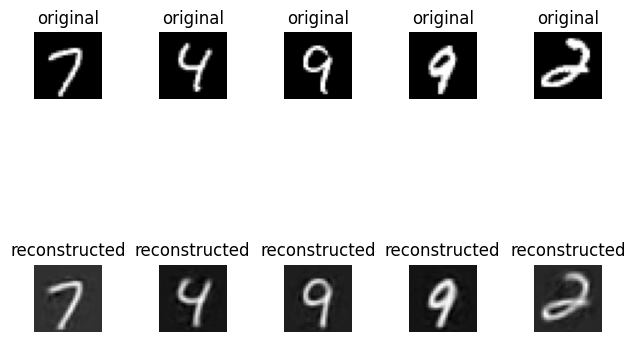

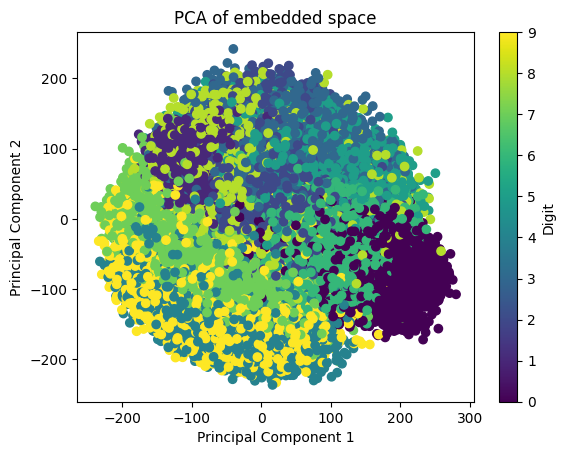

fitted pca
fitting umap


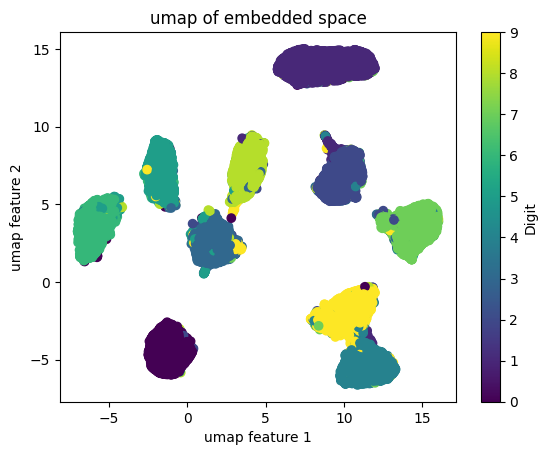

fitted umap
fitting pca


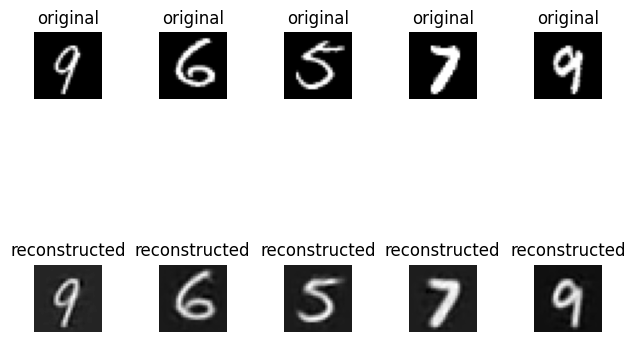

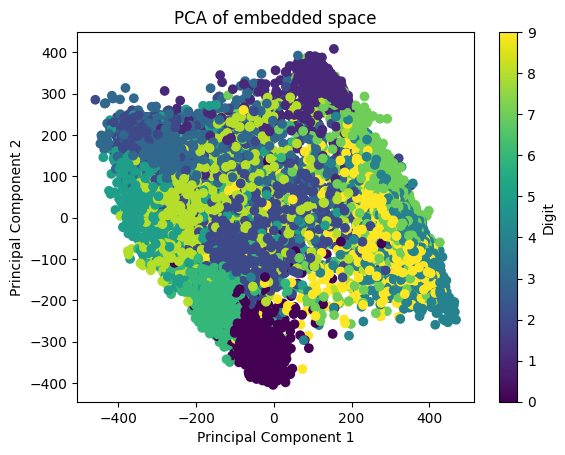

fitted pca
fitting umap


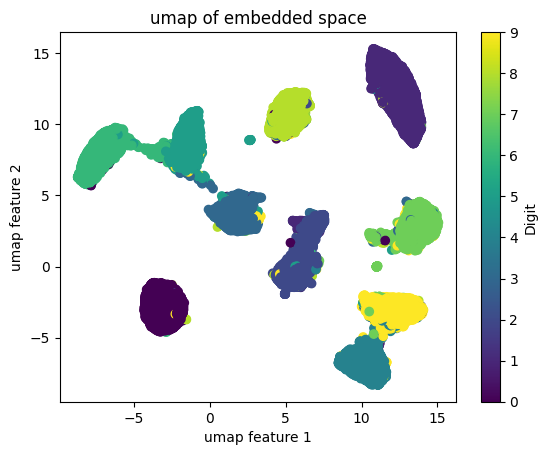

fitted umap


In [21]:
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/pretrained_AE.pth"))
autoencoder.fitted = True
visualize_peformance_AE(autoencoder, dataset, labels, (28,28), 5)

visualize_peformance_AE(dipect.autoencoder, dataset, labels, (28,28), 5)

In [38]:
import networkx as nx
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from clustpy.deep._utils import encode_batchwise
from clustpy.deep._data_utils import get_dataloader

def graphviz_layout_binary_tree(G, root):
    A = nx.nx_agraph.to_agraph(G)
    A.layout(prog='dot')  # 'dot' is used for hierarchical layouts
    pos = {}
    for node in G.nodes():
        x, y = A.get_node(node).attr['pos'].split(',')
        pos[node] = (float(x), float(y))
    return pos

def build_and_visualize_tree(root, autoencoder, data):
    if root is None:
        return
    testloader = get_dataloader(data, 256, False, False)
    embedded_data = encode_batchwise(testloader, autoencoder, "cpu")
    embedded_data = torch.from_numpy(embedded_data)

    # Create a directed graph
    G = nx.DiGraph()
    
    # Helper function to add nodes and edges to the graph
    def add_edges(G, node):
        if node.left_child:
            G.add_edge(node, node.left_child)
            add_edges(G, node.left_child)
        if node.right_child:
            G.add_edge(node, node.right_child)
            add_edges(G, node.right_child)
    
    # Add nodes and edges starting from the root
    add_edges(G, root)

    # Create a position dictionary for the nodes
    pos = graphviz_layout_binary_tree(G, root)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 15))
    nx.draw(G, pos, ax=ax, with_labels=False)
    
    # Draw the images at the nodes
    for node in G.nodes:
        image = np.mean(autoencoder.decode(embedded_data[node.assigned_indices]).detach().numpy(), axis=0)
        # image = autoencoder.decode(center).detach().numpy()
        image = image.reshape(28,28)
        
        # if dataset_type == DatasetType.USPS:
        #     image = image.reshape(16,16)
        # else:
        #     image = image.reshape(28,28)
        imagebox = OffsetImage(image, zoom=1)
        ab = AnnotationBbox(imagebox, pos[node], frameon=False)
        ax.add_artist(ab)
    
    plt.show()

from PIL import Image, ImageDraw, ImageFont

def integer_to_image(number, font_size=10, image_size=(28, 28), bg_color=(255, 255, 255), text_color=(0, 0, 0)):
    image = Image.new('RGB', image_size, bg_color)
    
    
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()

    text = str(number)
    bbox = draw.textbbox((0, 0), text, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    
  
    position = ((image_size[0] - text_width) / 2, (image_size[1] - text_height) / 2)
    

    draw.text(position, text, fill=text_color, font=font)
    
    return np.array(image)


def build_and_visualize_splitindex_tree(root):
    if root is None:
        return

    # Create a directed graph
    G = nx.DiGraph()
    
    # Helper function to add nodes and edges to the graph
    def add_edges(G, node):
        if node.left_child:
            G.add_edge(node, node.left_child)
            add_edges(G, node.left_child)
        if node.right_child:
            G.add_edge(node, node.right_child)
            add_edges(G, node.right_child)
    
    # Add nodes and edges starting from the root
    add_edges(G, root)

    # Create a position dictionary for the nodes
    pos = graphviz_layout_binary_tree(G, root)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 15))
    nx.draw(G, pos, ax=ax, with_labels=False)
    
    # Draw the images at the nodes
    for node in G.nodes:
        image = integer_to_image(node.split_id)
        # image = autoencoder.decode(center).detach().numpy()
        # image = image.reshape(28,28)
        
        # if dataset_type == DatasetType.USPS:
        #     image = image.reshape(16,16)
        # else:
        #     image = image.reshape(28,28)
        imagebox = OffsetImage(image, zoom=1)
        ab = AnnotationBbox(imagebox, pos[node], frameon=False)
        ax.add_artist(ab)
    
    plt.show()
# def visualize_cluster_tree(dataset_type: DatasetType, autoencoder_type: AutoencoderType):
#     dataset = get_dataset(dataset_type)

#     data = dataset["data"]
#     labels = dataset["target"]

#     autoencoder = pretraining(autoencoder_type, None, dataset, 42, 10)

#     deepect = deepect_paper.DeepECT(
#         autoencoder=autoencoder,
#         clustering_optimizer_params={"lr": 1e-4, "betas": (0.9, 0.999)},
#         max_leaf_nodes=20,
#         random_state=np.random.RandomState(42),
#     )

#     deepect.fit_predict(data)

#     print("Accuracy: ", deepect.tree_.flat_accuracy(labels, 10))

#     build_and_visualize_tree(deepect.tree_.root, autoencoder, dataset_type)

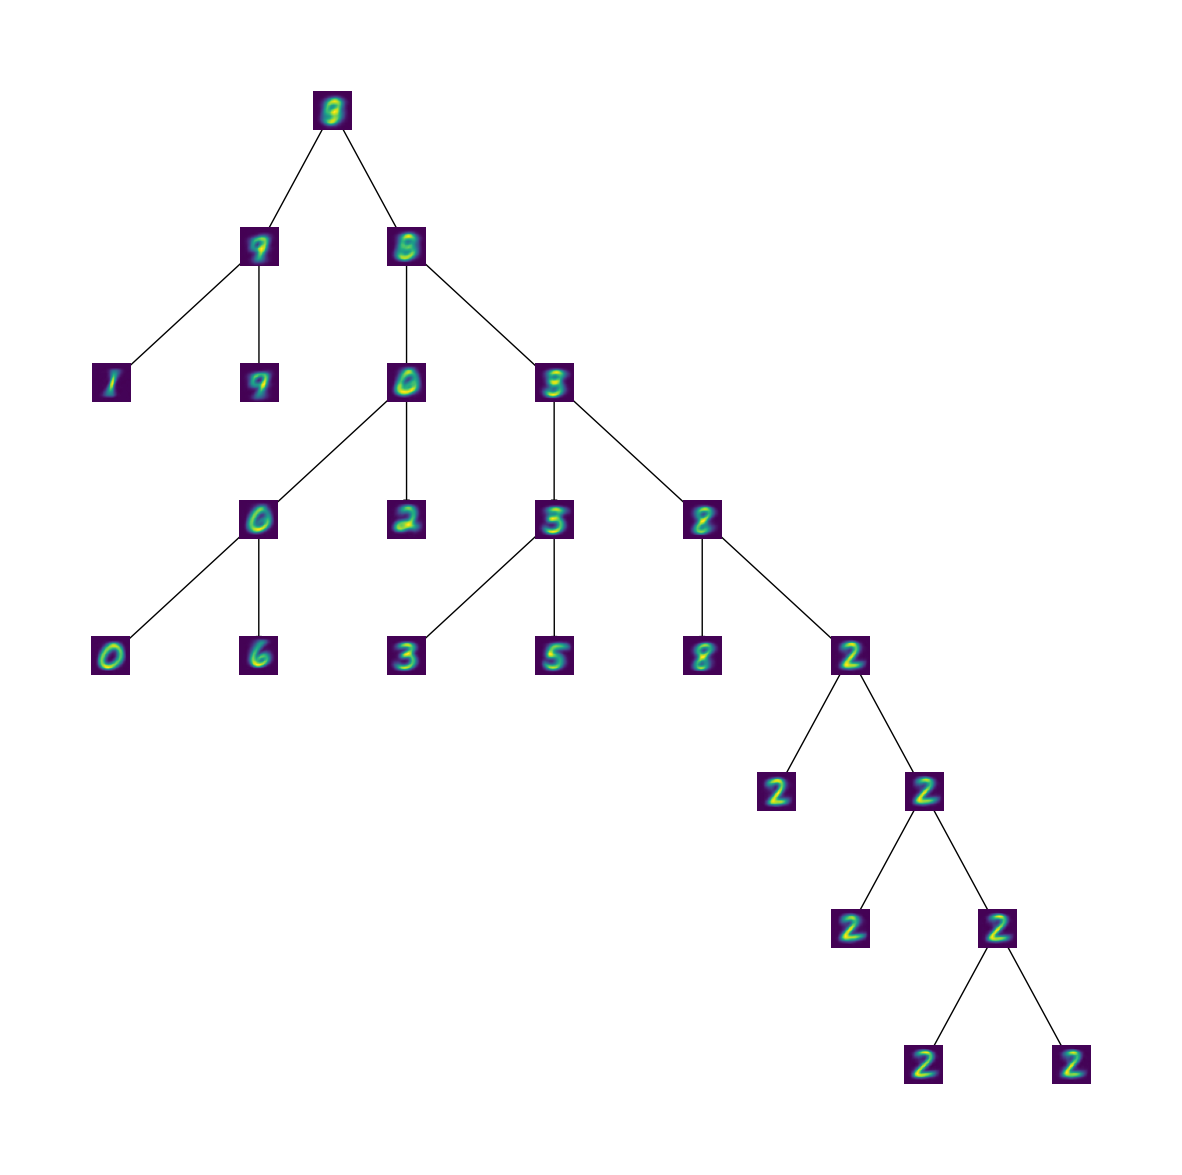

In [26]:
build_and_visualize_tree(dipect.tree_.root, dipect.autoencoder, dataset)

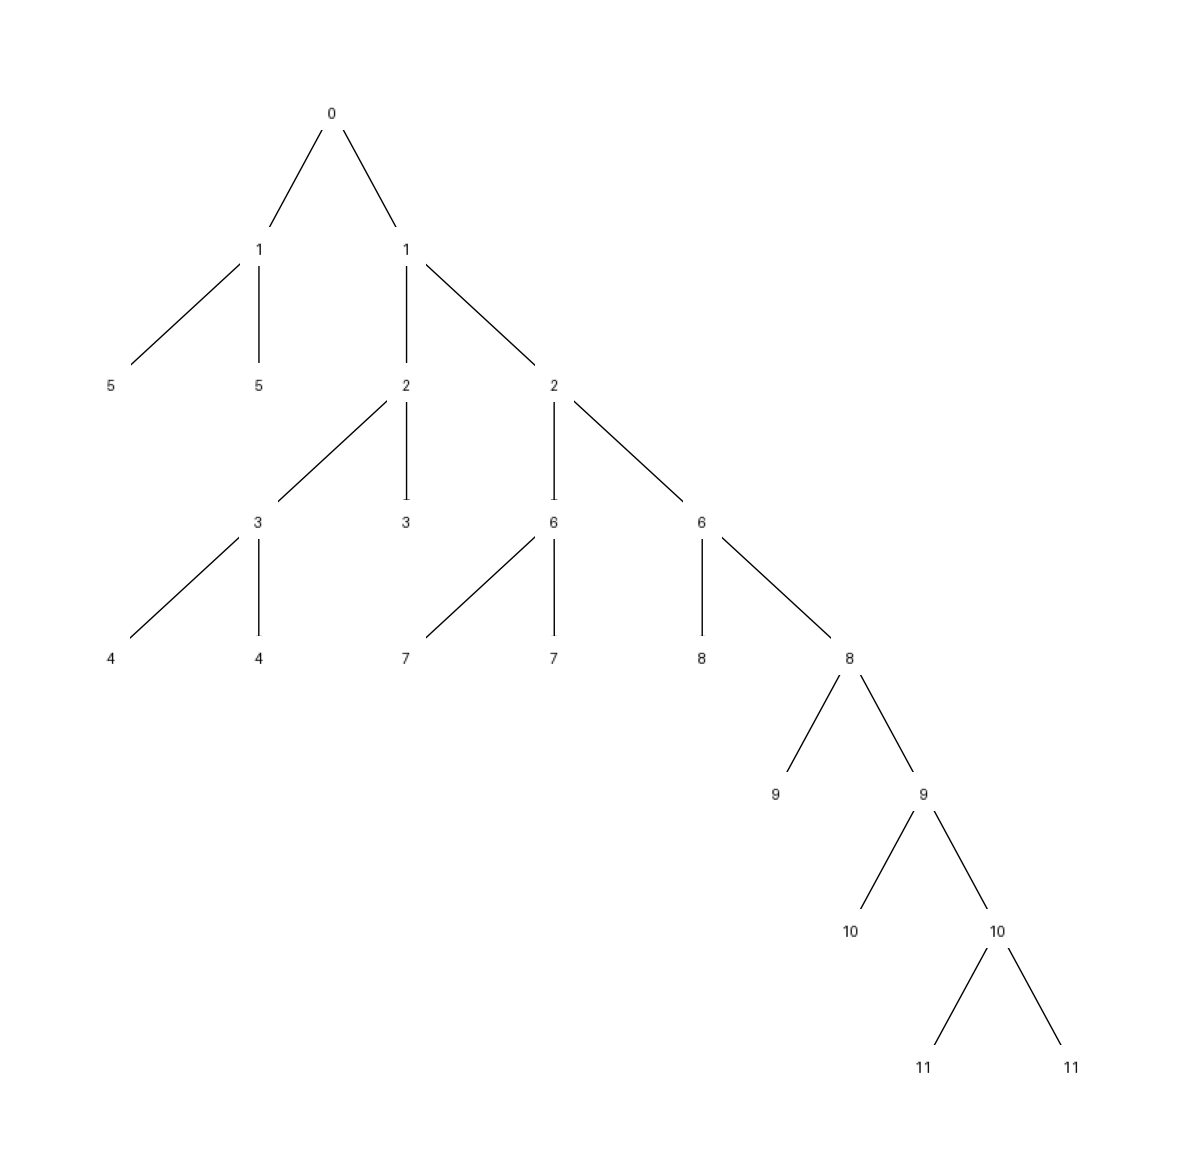

In [39]:
build_and_visualize_splitindex_tree(dipect.tree_.root)

/home/schilcherj/master/deepClustering/deepClustEnv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/schilcherj/master/deepClustering/deepClustEnv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


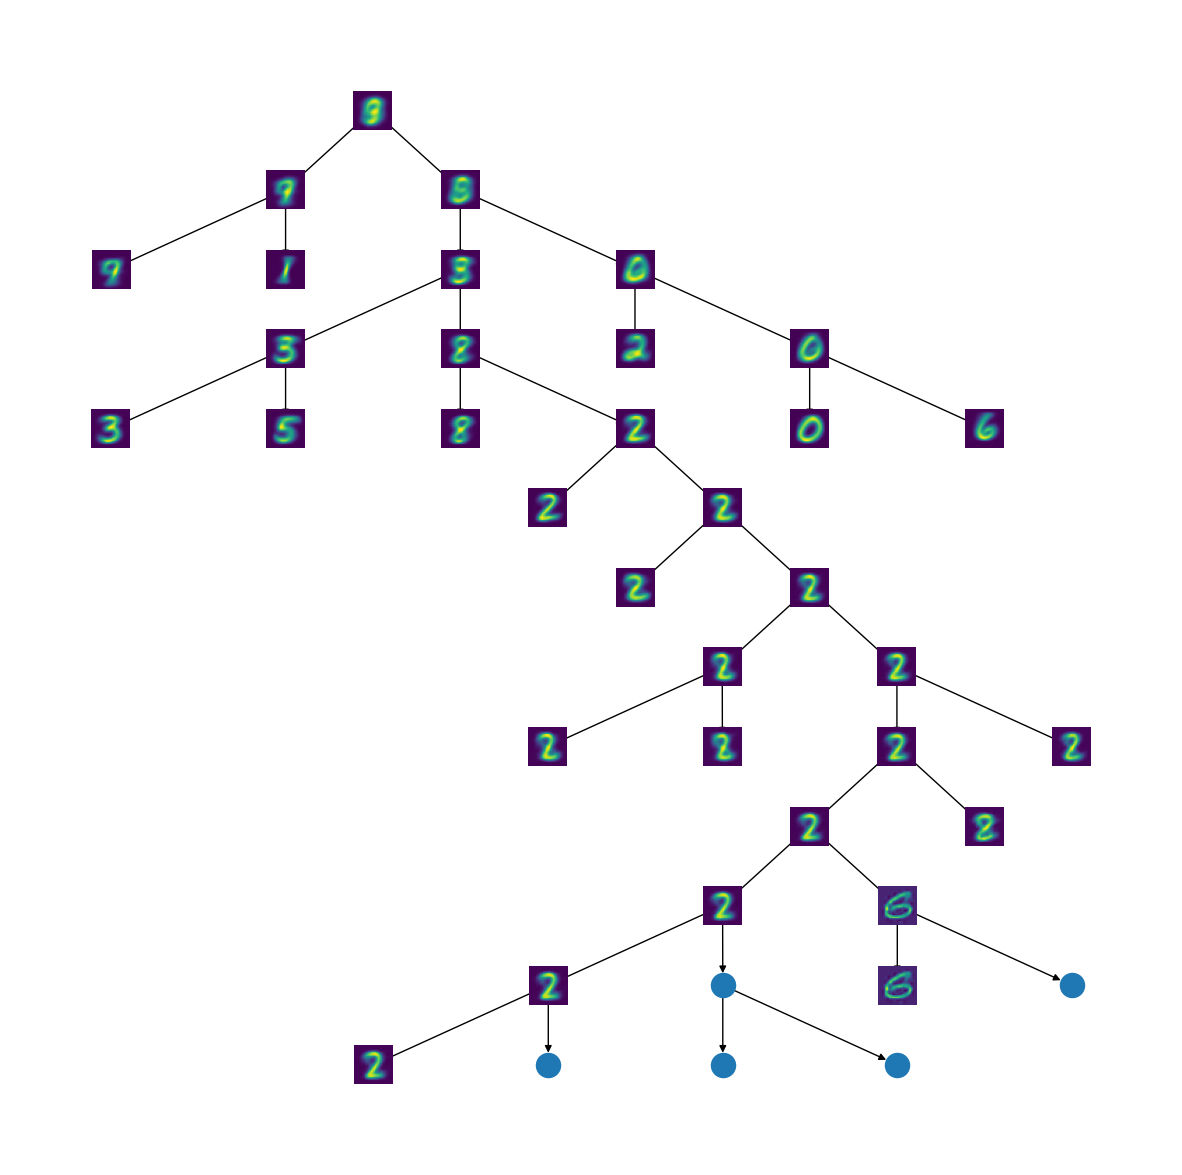

In [32]:
build_and_visualize_tree(dipect_bigger_tree.tree_.root, dipect_bigger_tree.autoencoder, dataset)

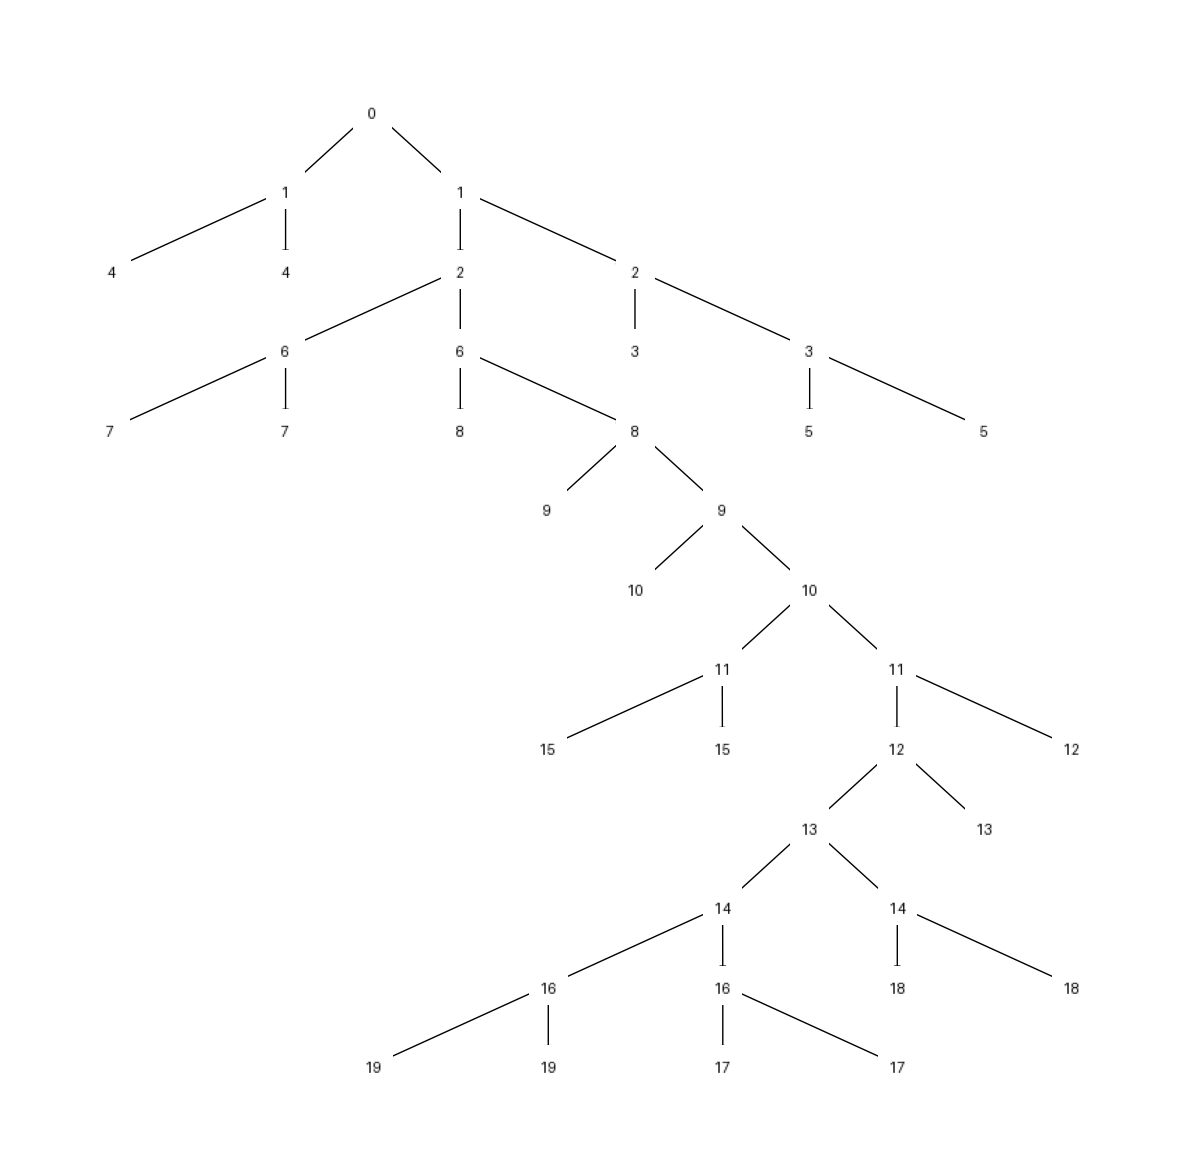

In [40]:
build_and_visualize_splitindex_tree(dipect_bigger_tree.tree_.root)

/home/schilcherj/master/deepClustering/deepClustEnv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/schilcherj/master/deepClustering/deepClustEnv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


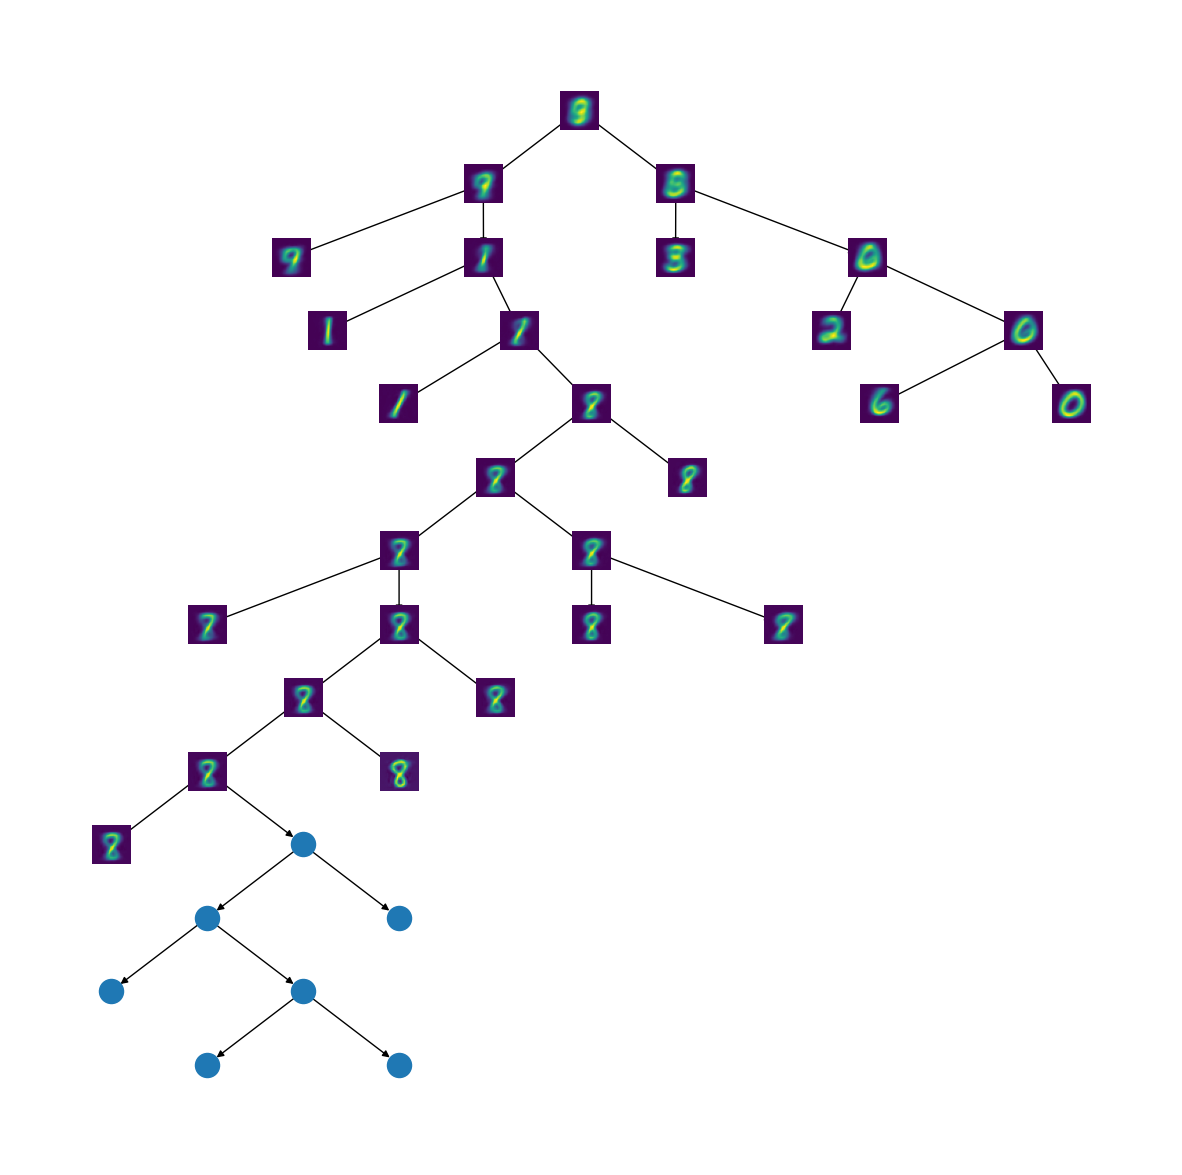

In [44]:
build_and_visualize_tree(dipect_view_iterations.tree_.root, dipect_view_iterations.autoencoder, dataset)

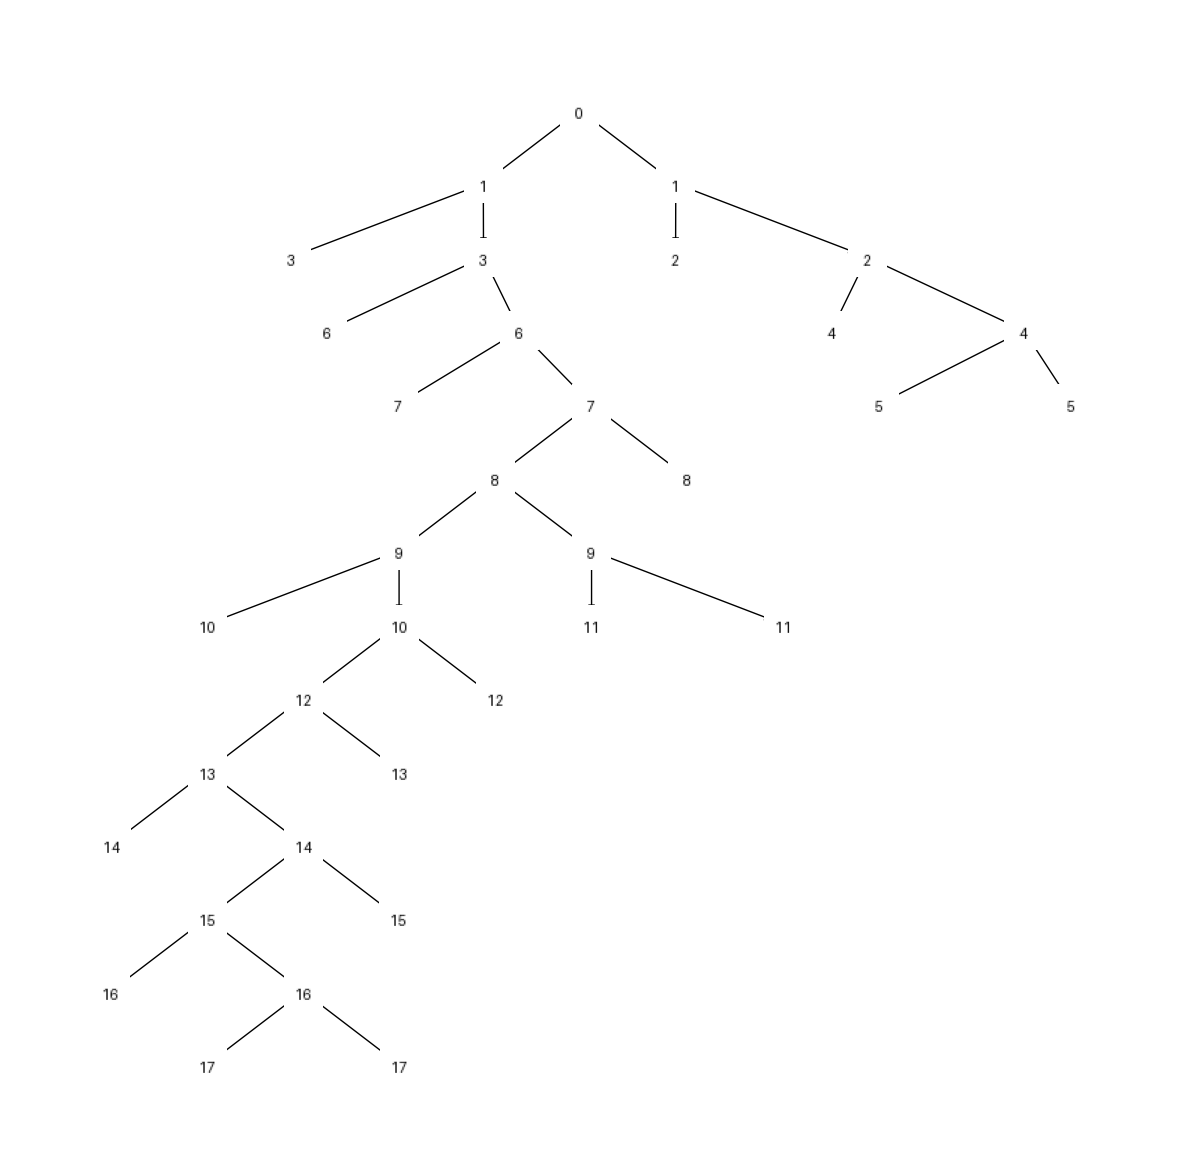

In [45]:
build_and_visualize_splitindex_tree(dipect_view_iterations.tree_.root)


In [49]:
dataset, labels = load_mnist(return_X_y=True)
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/pretrained_AE.pth"))
autoencoder.fitted = True

dipect_test = DipECT(autoencoder=autoencoder, grow_interval=100, max_iterations=2000)
dipect_test = dipect_test.fit_predict(dataset)

cpu


Fit:   5%|▌         | 100/2000 [00:12<04:18,  7.35it/s]

#assignments:  28926
#assignments:  31074
#assignments best node:  28926


Fit:  10%|█         | 200/2000 [00:35<03:41,  8.13it/s]  

#assignments:  10202
#assignments:  17271
#assignments:  32527
#assignments best node:  32527


Fit:  15%|█▌        | 300/2000 [01:00<04:05,  6.93it/s]  

#assignments:  9662
#assignments:  17503
#assignments:  15802
#assignments:  17033
#assignments best node:  15802


Fit:  20%|██        | 400/2000 [01:26<03:43,  7.15it/s]  

#assignments:  8779
#assignments:  17488
#assignments:  9484
#assignments:  7319
#assignments:  16930
#assignments best node:  9484


Fit:  25%|██▌       | 500/2000 [01:53<03:42,  6.73it/s]  

#assignments:  8116
#assignments:  17606
#assignments:  5036
#assignments:  5309
#assignments:  7226
#assignments:  16707
#assignments best node:  16707


Fit:  30%|███       | 600/2000 [02:20<03:51,  6.04it/s]  

#assignments:  8224
#assignments:  17586
#assignments:  5060
#assignments:  5223
#assignments:  7428
#assignments:  4016
#assignments:  12463
#assignments best node:  7428


Fit:  35%|███▌      | 700/2000 [02:49<03:09,  6.87it/s]  

#assignments:  7848
#assignments:  17619
#assignments:  4932
#assignments:  5233
#assignments:  6335
#assignments:  1310
#assignments:  4355
#assignments:  12368
#assignments best node:  12368


Fit:  40%|████      | 800/2000 [03:27<07:35,  2.63it/s]  

#assignments:  7703
#assignments:  17621
#assignments:  5114
#assignments:  5364
#assignments:  6291
#assignments:  1303
#assignments:  4330
#assignments:  6305
#assignments:  5969
#assignments best node:  1303


Fit:  45%|████▌     | 900/2000 [04:07<03:34,  5.13it/s]  

#assignments:  7572
#assignments:  17707
#assignments:  5121
#assignments:  5341
#assignments:  6313
#assignments:  802
#assignments:  656
#assignments:  4304
#assignments:  6305
#assignments:  5879
#assignments best node:  656


Fit:  50%|█████     | 1000/2000 [04:42<03:05,  5.40it/s] 

#assignments:  7586
#assignments:  17646
#assignments:  5132
#assignments:  5327
#assignments:  6259
#assignments:  796
#assignments:  412
#assignments:  397
#assignments:  4302
#assignments:  6246
#assignments:  5897
#assignments best node:  412


Fit:  55%|█████▌    | 1100/2000 [05:13<02:12,  6.77it/s]  

#assignments:  7482
#assignments:  17801
#assignments:  5131
#assignments:  5348
#assignments:  6232
#assignments:  624
#assignments:  169
#assignments:  321
#assignments:  520
#assignments:  4278
#assignments:  6218
#assignments:  5876
#assignments best node:  321


Fit:  60%|██████    | 1200/2000 [05:44<02:14,  5.96it/s]  

#assignments:  7451
#assignments:  17789
#assignments:  5181
#assignments:  5393
#assignments:  6231
#assignments:  1042
#assignments:  113
#assignments:  43
#assignments:  51
#assignments:  338
#assignments:  4287
#assignments:  6250
#assignments:  5831
#assignments best node:  43


Fit:  65%|██████▌   | 1300/2000 [06:26<02:22,  4.92it/s]  

#assignments:  7530
#assignments:  17768
#assignments:  5181
#assignments:  5396
#assignments:  6241
#assignments:  470
#assignments:  163
#assignments:  112
#assignments:  181
#assignments:  183
#assignments:  480
#assignments:  4254
#assignments:  6211
#assignments:  5830
#assignments best node:  112


Fit:  70%|███████   | 1400/2000 [06:59<01:38,  6.08it/s]

#assignments:  7389
#assignments:  17926
#assignments:  5162
#assignments:  5349
#assignments:  6279
#assignments:  584
#assignments:  156
#assignments:  26
#assignments:  24
#assignments:  24
#assignments:  174
#assignments:  599
#assignments:  4311
#assignments:  6176
#assignments:  5821
#assignments best node:  24


Fit:  75%|███████▌  | 1500/2000 [07:31<01:21,  6.11it/s]

#assignments:  7379
#assignments:  17796
#assignments:  5264
#assignments:  5408
#assignments:  6186
#assignments:  484
#assignments:  247
#assignments:  15
#assignments:  52
#assignments:  32
#assignments:  16
#assignments:  132
#assignments:  667
#assignments:  4340
#assignments:  6188
#assignments:  5794
#assignments best node:  16


Fit:  80%|████████  | 1600/2000 [08:02<01:02,  6.38it/s]

#assignments:  7361
#assignments:  17863
#assignments:  5249
#assignments:  5396
#assignments:  6193
#assignments:  1133
#assignments:  57
#assignments:  24
#assignments:  18
#assignments:  14
#assignments:  5
#assignments:  5
#assignments:  34
#assignments:  293
#assignments:  4363
#assignments:  6194
#assignments:  5798
#assignments best node:  18


Fit:  85%|████████▌ | 1700/2000 [08:44<00:55,  5.40it/s]

#assignments:  7367
#assignments:  17832
#assignments:  5230
#assignments:  5383
#assignments:  6259
#assignments:  902
#assignments:  166
#assignments:  7
#assignments:  9
#assignments:  5
#assignments:  23
#assignments:  11
#assignments:  9
#assignments:  172
#assignments:  399
#assignments:  4280
#assignments:  6169
#assignments:  5777
#assignments best node:  9


Fit:  90%|█████████ | 1800/2000 [09:32<00:42,  4.71it/s]

#assignments:  7328
#assignments:  17872
#assignments:  5163
#assignments:  5393
#assignments:  6280
#assignments:  598
#assignments:  318
#assignments:  35
#assignments:  7
#assignments:  9
#assignments:  8
#assignments:  10
#assignments:  29
#assignments:  9
#assignments:  170
#assignments:  519
#assignments:  4303
#assignments:  6153
#assignments:  5796
#assignments best node:  10


Fit: 2001it [11:28,  2.91it/s]                          
Predict: 100%|██████████| 235/235 [00:11<00:00, 20.43it/s]


In [50]:
print(dipect_test.tree_.flat_accuracy(labels, 10))
print(dipect_test.tree_.flat_nmi(labels, 10))

0.7232
0.7757994560891956


In [58]:
dataset, labels = load_mnist(return_X_y=True)
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/pretrained_AE.pth"))
autoencoder.fitted = True

dipect_test_2 = DipECT(autoencoder=autoencoder, grow_interval=200, max_iterations=10000, consider_num_assignments_for_growing=True)
dipect_test_2 = dipect_test_2.fit_predict(dataset)

cpu


Fit:   2%|▏         | 200/10000 [02:51<1:58:24,  1.38it/s]

inside
#assignments:  28806
#assignments:  31194
#assignments best node:  31194


Fit:   4%|▍         | 400/10000 [06:30<3:38:49,  1.37s/it] 

inside
#assignments:  28567
#assignments:  16378
#assignments:  15055
#assignments best node:  28567


Fit:   6%|▌         | 600/10000 [09:36<1:37:35,  1.61it/s] 

inside
#assignments:  9561
#assignments:  17909
#assignments:  16332
#assignments:  16198
#assignments best node:  16198


Fit:   8%|▊         | 800/10000 [11:51<1:24:13,  1.82it/s] 

inside
#assignments:  9823
#assignments:  17775
#assignments:  16422
#assignments:  8674
#assignments:  7306
#assignments best node:  17775


Fit:  10%|█         | 1000/10000 [14:01<1:23:21,  1.80it/s]

inside
#assignments:  9397
#assignments:  5875
#assignments:  11832
#assignments:  16272
#assignments:  9464
#assignments:  7160
#assignments best node:  9464


Fit:  12%|█▏        | 1200/10000 [16:18<1:19:09,  1.85it/s] 

inside
#assignments:  9383
#assignments:  5862
#assignments:  11810
#assignments:  16262
#assignments:  4041
#assignments:  5370
#assignments:  7272
#assignments best node:  16262


Fit:  14%|█▍        | 1400/10000 [18:32<1:19:05,  1.81it/s] 

inside
#assignments:  8861
#assignments:  5932
#assignments:  11828
#assignments:  12023
#assignments:  4208
#assignments:  4399
#assignments:  5382
#assignments:  7367
#assignments best node:  12023


Fit:  16%|█▌        | 1600/10000 [20:53<1:19:28,  1.76it/s] 

inside
#assignments:  8920
#assignments:  5985
#assignments:  11787
#assignments:  6236
#assignments:  5741
#assignments:  4239
#assignments:  4258
#assignments:  5382
#assignments:  7452
#assignments best node:  7452


Fit:  18%|█▊        | 1800/10000 [23:05<1:21:04,  1.69it/s] 

inside
#assignments:  9136
#assignments:  5994
#assignments:  11872
#assignments:  6181
#assignments:  5736
#assignments:  4249
#assignments:  3919
#assignments:  5389
#assignments:  6306
#assignments:  1218
#assignments best node:  11872


Fit:  20%|██        | 2000/10000 [25:35<1:33:38,  1.42it/s] 

inside
#assignments:  8852
#assignments:  6038
#assignments:  6275
#assignments:  5488
#assignments:  6220
#assignments:  5712
#assignments:  4271
#assignments:  4169
#assignments:  5422
#assignments:  6228
#assignments:  1325
#assignments best node:  5488


Fit:  22%|██▏       | 2200/10000 [28:18<1:17:42,  1.67it/s] 

inside
#assignments:  9042
#assignments:  6101
#assignments:  6162
#assignments:  2542
#assignments:  2958
#assignments:  6189
#assignments:  5690
#assignments:  4328
#assignments:  3987
#assignments:  5449
#assignments:  6216
#assignments:  1336
#assignments best node:  6162


Fit:  24%|██▍       | 2400/10000 [30:42<1:22:29,  1.54it/s] 

inside
#assignments:  8822
#assignments:  6223
#assignments:  3111
#assignments:  2974
#assignments:  2629
#assignments:  2909
#assignments:  6169
#assignments:  5762
#assignments:  4371
#assignments:  3993
#assignments:  5396
#assignments:  6235
#assignments:  1406
#assignments best node:  8822


Fit:  26%|██▌       | 2600/10000 [33:25<1:16:56,  1.60it/s] 

inside
#assignments:  3647
#assignments:  4895
#assignments:  6156
#assignments:  3078
#assignments:  2943
#assignments:  2686
#assignments:  2957
#assignments:  6145
#assignments:  5720
#assignments:  4351
#assignments:  4244
#assignments:  5392
#assignments:  6259
#assignments:  1527
#assignments best node:  4895


Fit:  28%|██▊       | 2800/10000 [35:58<1:12:26,  1.66it/s] 

inside
#assignments:  3704
#assignments:  3481
#assignments:  1494
#assignments:  6146
#assignments:  3099
#assignments:  2970
#assignments:  2642
#assignments:  2907
#assignments:  6120
#assignments:  5748
#assignments:  4359
#assignments:  4228
#assignments:  5374
#assignments:  6203
#assignments:  1525
#assignments best node:  6146


Fit:  30%|███       | 3000/10000 [37:37<25:54,  4.50it/s]   

inside
#assignments:  3880
#assignments:  3234
#assignments:  1086
#assignments:  1786
#assignments:  4422
#assignments:  3078
#assignments:  2936
#assignments:  2677
#assignments:  2933
#assignments:  6104
#assignments:  5768
#assignments:  4368
#assignments:  4603
#assignments:  5390
#assignments:  6211
#assignments:  1524
#assignments best node:  6211


Fit:  32%|███▏      | 3200/10000 [38:25<16:37,  6.81it/s]   

inside
#assignments:  3771
#assignments:  3361
#assignments:  1451
#assignments:  1695
#assignments:  4541
#assignments:  3096
#assignments:  2940
#assignments:  2712
#assignments:  2924
#assignments:  6091
#assignments:  5743
#assignments:  4358
#assignments:  4184
#assignments:  5377
#assignments:  2609
#assignments:  3642
#assignments:  1505
#assignments best node:  6091


Fit:  34%|███▍      | 3400/10000 [39:16<15:42,  7.00it/s]   

inside
#assignments:  3818
#assignments:  3310
#assignments:  1219
#assignments:  1728
#assignments:  4475
#assignments:  3000
#assignments:  2909
#assignments:  2716
#assignments:  2943
#assignments:  3172
#assignments:  2910
#assignments:  5762
#assignments:  4408
#assignments:  4455
#assignments:  5369
#assignments:  3483
#assignments:  2787
#assignments:  1536
#assignments best node:  5762


Fit:  36%|███▌      | 3600/10000 [40:11<16:01,  6.66it/s]   

inside
#assignments:  3836
#assignments:  3331
#assignments:  1419
#assignments:  1841
#assignments:  4363
#assignments:  2946
#assignments:  2871
#assignments:  2763
#assignments:  2965
#assignments:  2609
#assignments:  3467
#assignments:  2721
#assignments:  3028
#assignments:  4374
#assignments:  4321
#assignments:  5377
#assignments:  3312
#assignments:  2912
#assignments:  1544
#assignments best node:  5377


Fit: 10001it [1:02:45,  2.66it/s]                           
Predict: 100%|██████████| 235/235 [00:05<00:00, 42.84it/s]


In [59]:
print(dipect_test_2.tree_.flat_accuracy(labels, 10))
print(dipect_test_2.tree_.flat_nmi(labels, 10))

0.8225333333333333
0.8341760347557395


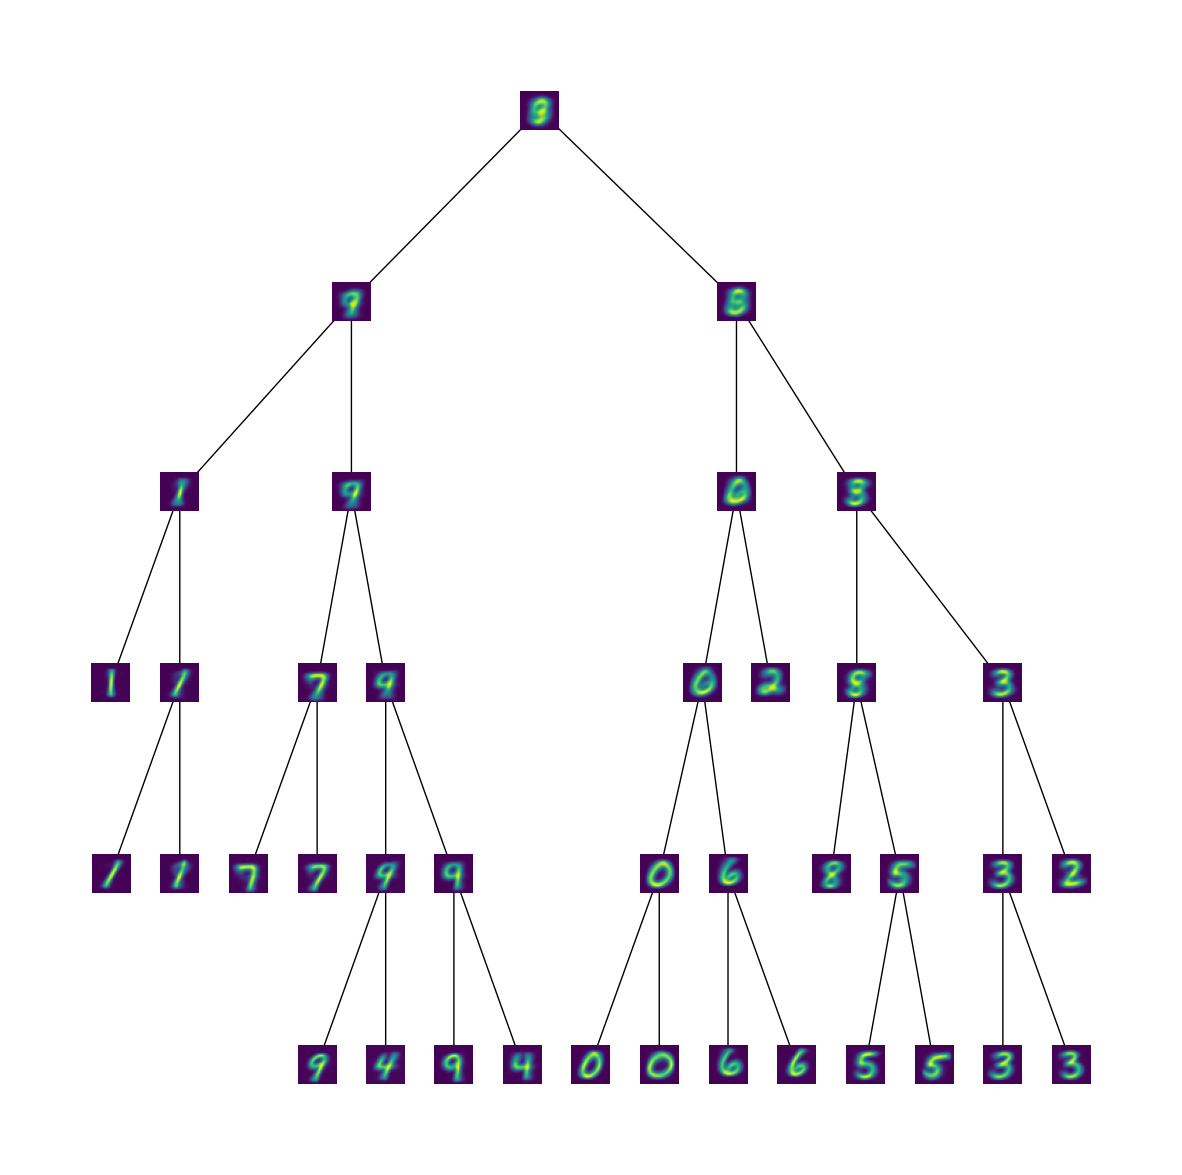

In [60]:
build_and_visualize_tree(dipect_test_2.tree_.root, dipect_test_2.autoencoder, dataset)

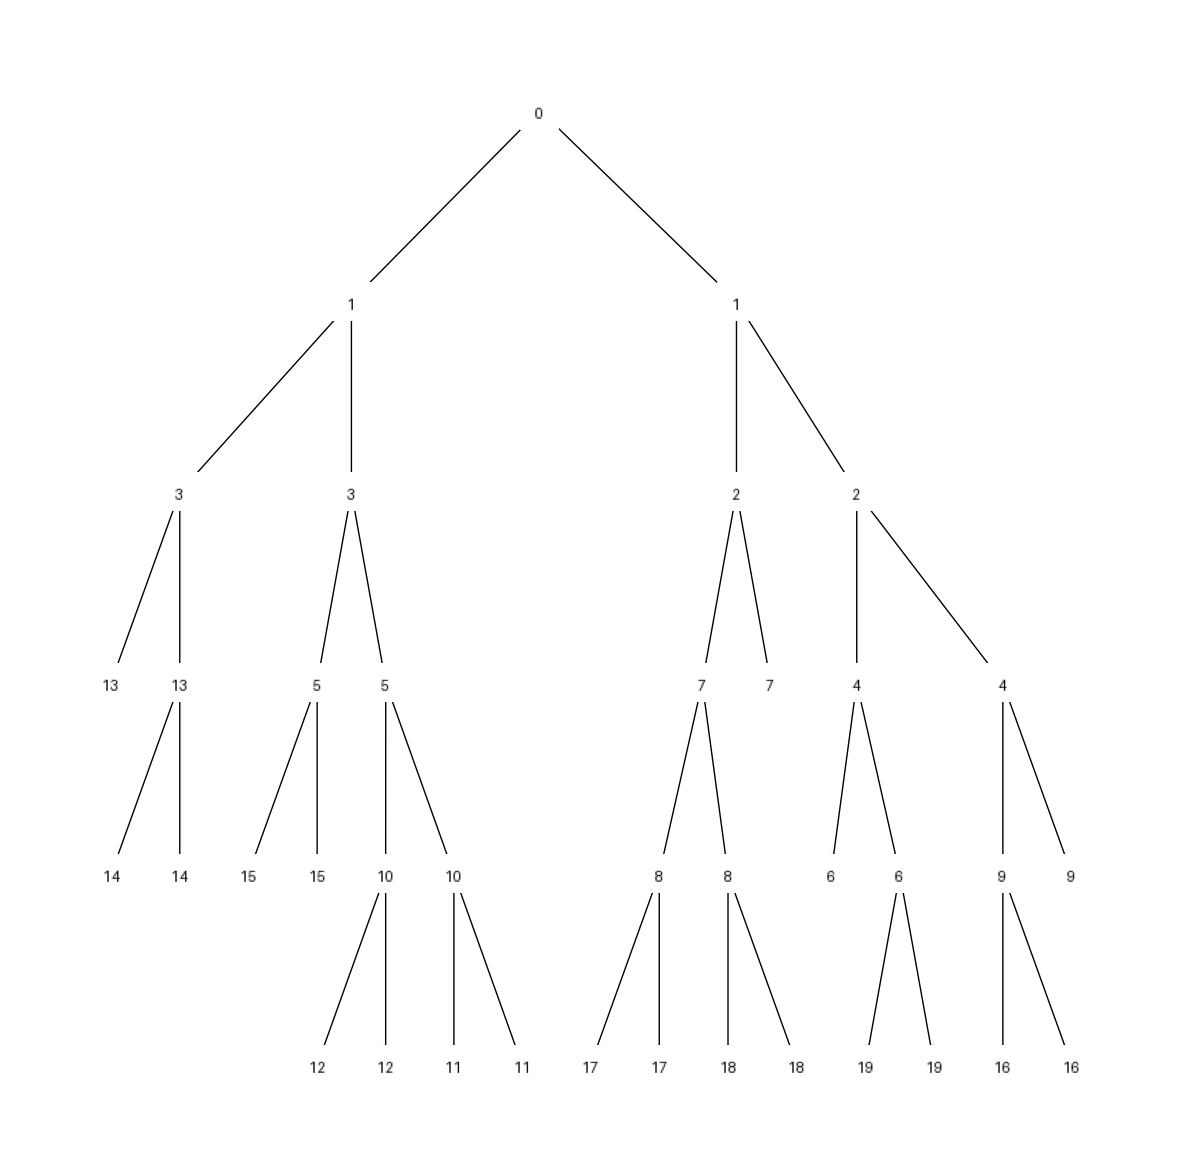

In [61]:
build_and_visualize_splitindex_tree(dipect_test_2.tree_.root)

fitting pca


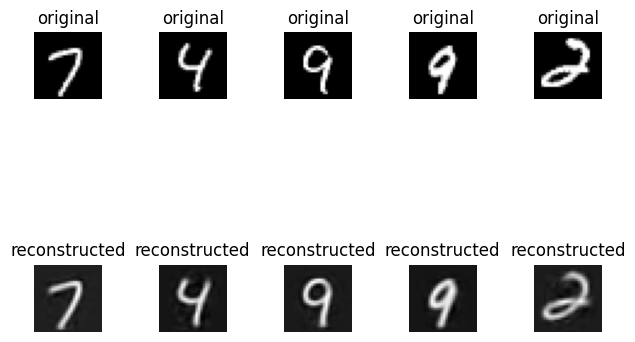

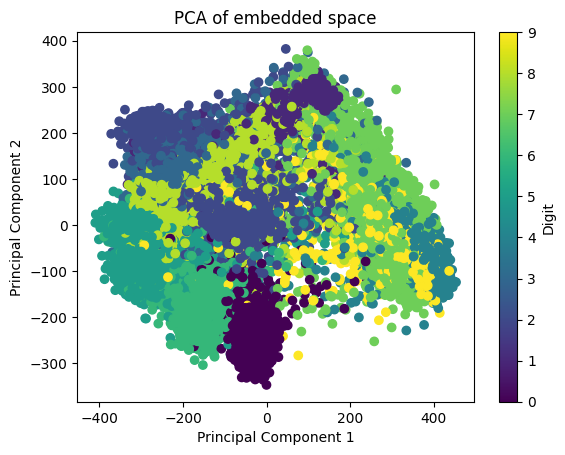

fitted pca
fitting umap


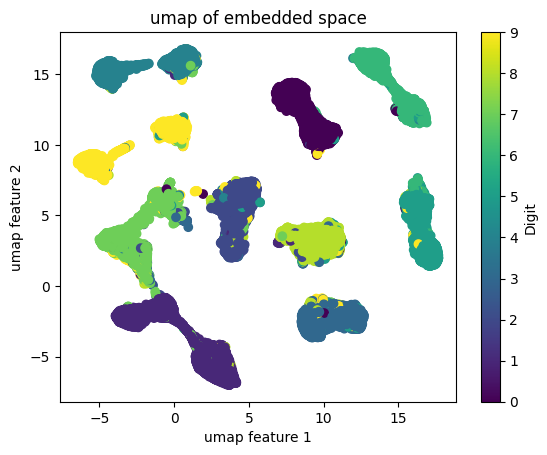

fitted umap


In [62]:
visualize_peformance_AE(dipect_test_2.autoencoder, dataset, labels, (28,28), 5)

In [176]:

autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/pretrained_AE.pth"))
autoencoder.fitted = True

dipect_test = DipECT(autoencoder=autoencoder, grow_interval=400, max_iterations=8000, consider_num_assignments_for_growing=True)
dipect_test = dipect_test.fit_predict(dataset)

cpu


Fit:   5%|▍         | 399/8000 [00:36<11:48, 10.73it/s]

inside
#assignments:  27012
#assignments:  32988
#assignments best node:  32988


Fit:  10%|█         | 800/8000 [01:27<11:11, 10.72it/s]  

inside
#assignments:  25918
#assignments:  17393
#assignments:  16689
#assignments best node:  25918


Fit:  15%|█▍        | 1199/8000 [02:12<09:51, 11.50it/s] 

inside
#assignments:  7518
#assignments:  18144
#assignments:  17834
#assignments:  16504
#assignments best node:  17834


Fit:  20%|█▉        | 1599/8000 [03:05<11:50,  9.02it/s]  

inside
#assignments:  7284
#assignments:  17980
#assignments:  6690
#assignments:  11626
#assignments:  16420
#assignments best node:  11626


Fit:  25%|██▌       | 2000/8000 [04:16<24:41,  4.05it/s]  

inside
#assignments:  7181
#assignments:  18017
#assignments:  7021
#assignments:  5497
#assignments:  5992
#assignments:  16292
#assignments best node:  18017


Fit:  30%|███       | 2400/8000 [05:42<10:32,  8.85it/s]  

inside
#assignments:  7100
#assignments:  10379
#assignments:  7555
#assignments:  7178
#assignments:  5459
#assignments:  6042
#assignments:  16287
#assignments best node:  16287


Fit:  35%|███▍      | 2799/8000 [07:24<10:10,  8.52it/s]  

inside
#assignments:  7079
#assignments:  10242
#assignments:  7743
#assignments:  7089
#assignments:  5529
#assignments:  6007
#assignments:  5766
#assignments:  10545
#assignments best node:  10545


Fit:  40%|████      | 3200/8000 [09:15<12:44,  6.28it/s]  

inside
#assignments:  7058
#assignments:  10318
#assignments:  7777
#assignments:  7186
#assignments:  5520
#assignments:  5958
#assignments:  5810
#assignments:  4199
#assignments:  6174
#assignments best node:  10318


Fit:  45%|████▍     | 3599/8000 [11:14<07:27,  9.83it/s]  

inside
#assignments:  7004
#assignments:  4274
#assignments:  5870
#assignments:  7824
#assignments:  7256
#assignments:  5521
#assignments:  6018
#assignments:  5838
#assignments:  4246
#assignments:  6149
#assignments best node:  7256


Fit:  50%|█████     | 4000/8000 [13:14<14:36,  4.56it/s]  

inside
#assignments:  7031
#assignments:  4253
#assignments:  5874
#assignments:  7923
#assignments:  5558
#assignments:  1611
#assignments:  5496
#assignments:  5986
#assignments:  5876
#assignments:  4259
#assignments:  6133
#assignments best node:  7923


Fit:  55%|█████▌    | 4400/8000 [15:05<11:38,  5.15it/s]  

inside
#assignments:  7000
#assignments:  4368
#assignments:  5836
#assignments:  3891
#assignments:  4001
#assignments:  5542
#assignments:  1631
#assignments:  5468
#assignments:  5949
#assignments:  5927
#assignments:  4270
#assignments:  6117
#assignments best node:  7000


Fit:  60%|██████    | 4800/8000 [17:10<44:51,  1.19it/s]  

inside
#assignments:  3403
#assignments:  3603
#assignments:  4404
#assignments:  5822
#assignments:  3797
#assignments:  4013
#assignments:  5639
#assignments:  1611
#assignments:  5439
#assignments:  5936
#assignments:  5913
#assignments:  4343
#assignments:  6077
#assignments best node:  5913


Fit:  65%|██████▌   | 5200/8000 [20:37<27:46,  1.68it/s]   

inside
#assignments:  3435
#assignments:  3602
#assignments:  4406
#assignments:  5826
#assignments:  3792
#assignments:  3949
#assignments:  5689
#assignments:  1637
#assignments:  5492
#assignments:  5972
#assignments:  3209
#assignments:  2670
#assignments:  4280
#assignments:  6041
#assignments best node:  5689


Fit:  70%|███████   | 5600/8000 [21:43<04:21,  9.18it/s]  

inside
#assignments:  3334
#assignments:  3668
#assignments:  4496
#assignments:  5812
#assignments:  3676
#assignments:  4029
#assignments:  3361
#assignments:  2282
#assignments:  1636
#assignments:  5515
#assignments:  5947
#assignments:  3140
#assignments:  2747
#assignments:  4345
#assignments:  6012
#assignments best node:  6012


Fit:  75%|███████▌  | 6000/8000 [22:47<04:15,  7.82it/s]  

inside
#assignments:  3365
#assignments:  3626
#assignments:  4477
#assignments:  5806
#assignments:  3674
#assignments:  3990
#assignments:  3301
#assignments:  2380
#assignments:  1634
#assignments:  5507
#assignments:  5981
#assignments:  2918
#assignments:  2946
#assignments:  4356
#assignments:  2778
#assignments:  3261
#assignments best node:  5981


Fit:  80%|████████  | 6400/8000 [24:24<03:12,  8.30it/s]  

inside
#assignments:  3414
#assignments:  3616
#assignments:  4487
#assignments:  5802
#assignments:  3720
#assignments:  3977
#assignments:  2736
#assignments:  2943
#assignments:  1650
#assignments:  5448
#assignments:  3028
#assignments:  2938
#assignments:  2996
#assignments:  2880
#assignments:  4324
#assignments:  2854
#assignments:  3187
#assignments best node:  5802


Fit:  85%|████████▌ | 6800/8000 [26:34<02:34,  7.75it/s]  

inside
#assignments:  3460
#assignments:  3538
#assignments:  4373
#assignments:  2310
#assignments:  3482
#assignments:  3846
#assignments:  3965
#assignments:  2753
#assignments:  2940
#assignments:  1634
#assignments:  5456
#assignments:  4104
#assignments:  1859
#assignments:  2980
#assignments:  2937
#assignments:  4368
#assignments:  2716
#assignments:  3279
#assignments best node:  5456


Fit:  90%|█████████ | 7200/8000 [30:25<04:26,  3.00it/s]  

inside
#assignments:  3354
#assignments:  3631
#assignments:  4452
#assignments:  2473
#assignments:  3310
#assignments:  3759
#assignments:  4004
#assignments:  3032
#assignments:  2685
#assignments:  1690
#assignments:  3011
#assignments:  2449
#assignments:  2761
#assignments:  3206
#assignments:  3008
#assignments:  2878
#assignments:  4293
#assignments:  2784
#assignments:  3220
#assignments best node:  4293


Fit: 8001it [34:01,  3.92it/s]                            
Predict: 100%|██████████| 235/235 [00:07<00:00, 30.17it/s]


In [177]:
print(dipect_test.tree_.flat_accuracy(labels, 10))
print(dipect_test.tree_.flat_nmi(labels, 10))

0.9113333333333333
0.8508044991636202


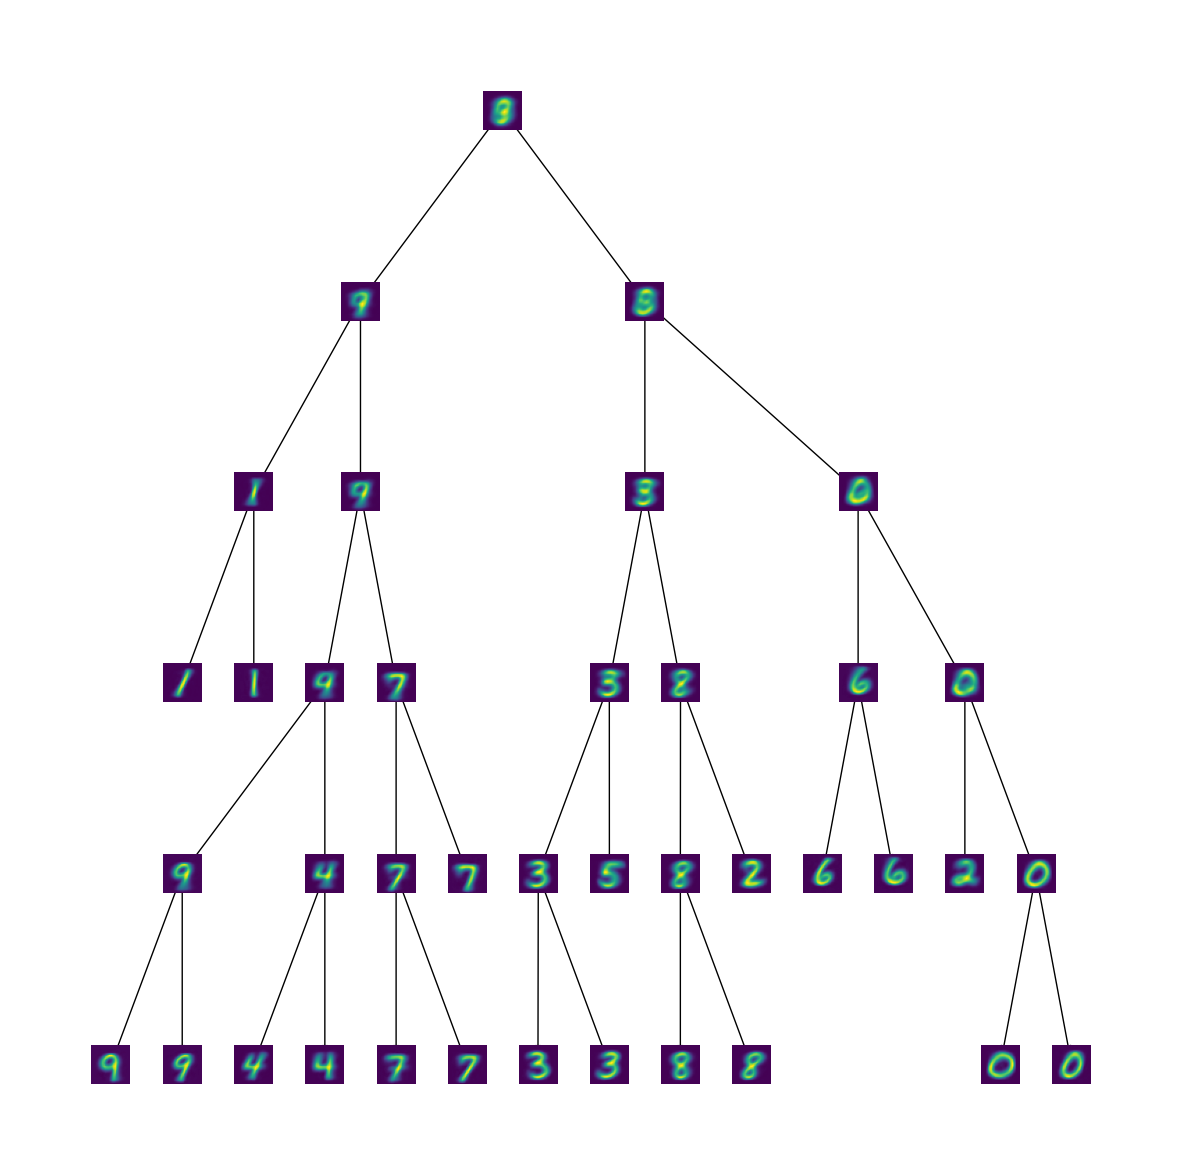

In [175]:
build_and_visualize_tree(dipect_test.tree_.root, dipect_test.autoencoder, dataset)

fitting pca


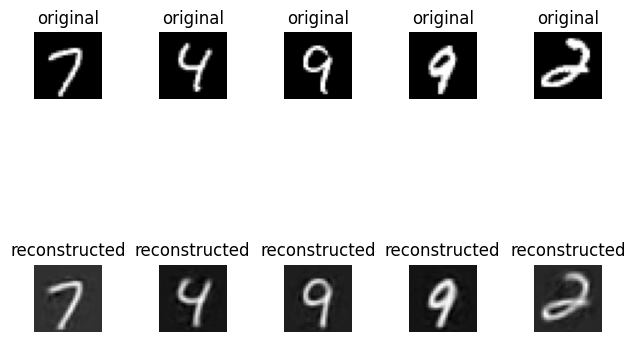

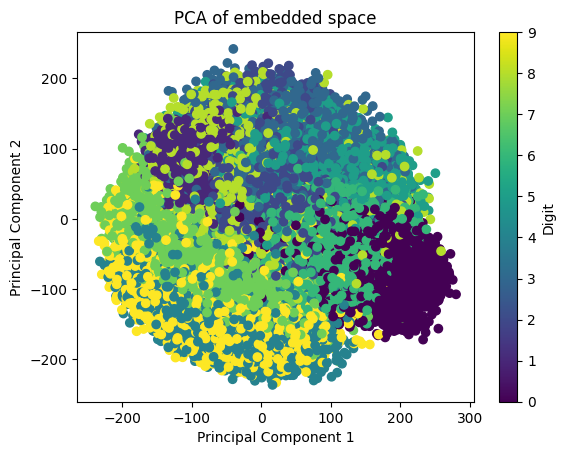

fitted pca
fitting umap


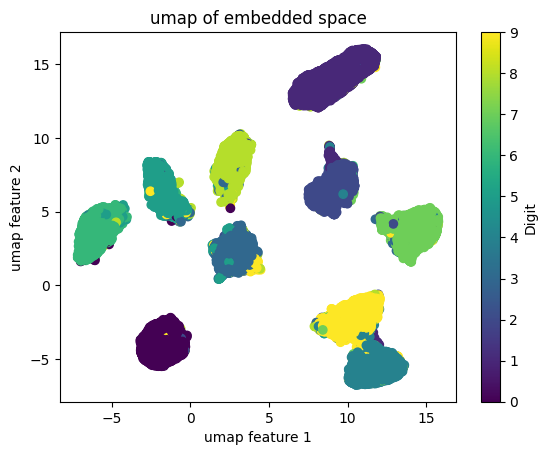

fitted umap
fitting pca


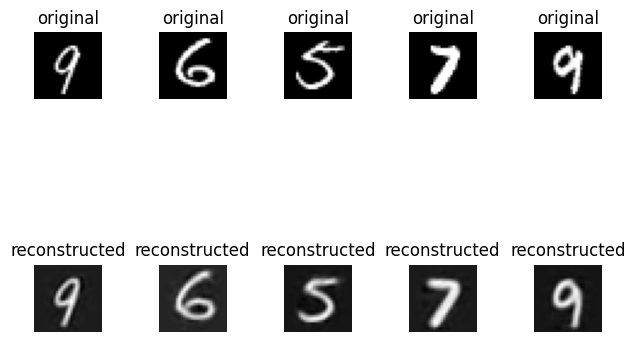

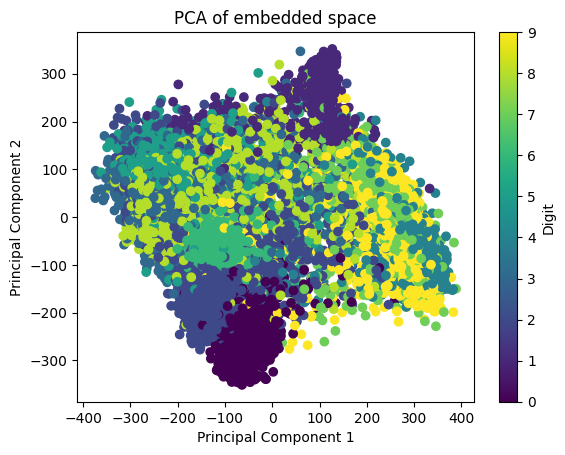

fitted pca
fitting umap


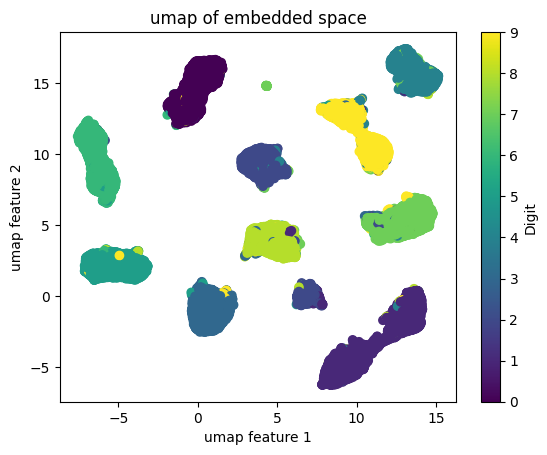

fitted umap


In [71]:
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/pretrained_AE.pth"))
autoencoder.fitted = True
visualize_peformance_AE(autoencoder, dataset, labels, (28,28), 5)

visualize_peformance_AE(dipect_test.autoencoder, dataset, labels, (28,28), 5)

In [ ]:
dataset, labels = load_mnist(return_X_y=True)
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/pretrained_AE.pth"))
autoencoder.fitted = True

dipect_test = DipECT(autoencoder=autoencoder, consider_num_assignments_for_growing=True, grow_interval=2, max_epochs=40)
dipect_test = dipect_test.fit_predict(dataset)

cpu


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  40466
#assignments:  29534


Epoch 2/40:   0%|          | 0/274 [00:06<?, ?batch/s]

#assignments best node:  40466


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  21841
#assignments:  19052
#assignments:  29107


Epoch 4/40:   0%|          | 0/274 [00:07<?, ?batch/s]

#assignments best node:  29107


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  21842
#assignments:  19033
#assignments:  20804
#assignments:  8321


Epoch 6/40:   0%|          | 1/274 [00:05<27:13,  5.98s/batch]

#assignments best node:  19033


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  21849
#assignments:  14001
#assignments:  5020
#assignments:  20838


Epoch 8/40:   0%|          | 0/274 [00:04<?, ?batch/s]

#assignments:  8292
#assignments best node:  21849


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8236
#assignments:  13644
#assignments:  13938
#assignments:  5064
#assignments:  20949
#assignments:  8169


Epoch 10/40:   0%|          | 0/274 [00:10<?, ?batch/s]

#assignments best node:  13644


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8553
#assignments:  7058
#assignments:  6515
#assignments:  13857
#assignments:  4956
#assignments:  20939
#assignments:  8122


Epoch 12/40:   0%|          | 0/274 [00:08<?, ?batch/s]

#assignments best node:  13857


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8564
#assignments:  7051
#assignments:  6499
#assignments:  6695
#assignments:  7123
#assignments:  5005
#assignments:  20883
#assignments:  8180


Epoch 14/40:   0%|          | 0/274 [00:11<?, ?batch/s]

#assignments best node:  20883


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8518
#assignments:  7049
#assignments:  6424
#assignments:  6767
#assignments:  7070
#assignments:  5130
#assignments:  12152
#assignments:  8742
#assignments:  8148


Epoch 16/40:   0%|          | 0/274 [00:13<?, ?batch/s]

#assignments best node:  12152


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8599
#assignments:  7053
#assignments:  6449
#assignments:  6699
#assignments:  7077
#assignments:  5064
#assignments:  6822
#assignments:  5029
#assignments:  9088
#assignments:  8120


Epoch 18/40:   0%|          | 0/274 [00:12<?, ?batch/s]

#assignments best node:  8599


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  2012
#assignments:  6672
#assignments:  7053
#assignments:  6440
#assignments:  6715
#assignments:  7044
#assignments:  5025
#assignments:  6823
#assignments:  4945
#assignments:  9185
#assignments:  8086


Epoch 20/40:   0%|          | 0/274 [00:15<?, ?batch/s]

#assignments best node:  9185


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  1985
#assignments:  6696
#assignments:  7030
#assignments:  6404
#assignments:  6737
#assignments:  7027
#assignments:  5039
#assignments:  6777
#assignments:  5031
#assignments:  4747
#assignments:  4401
#assignments:  8126


Epoch 22/40:   0%|          | 0/274 [00:17<?, ?batch/s]

#assignments best node:  8126


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  1985
#assignments:  6664
#assignments:  7044
#assignments:  6395
#assignments:  6739
#assignments:  7035
#assignments:  5083
#assignments:  6741
#assignments:  4929
#assignments:  4462
#assignments:  4776
#assignments:  3837
#assignments:  4310


Epoch 24/40:   0%|          | 0/274 [00:16<?, ?batch/s]

#assignments best node:  6739


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  1962
#assignments:  6694
#assignments:  7005
#assignments:  6453
#assignments:  3375
#assignments:  3315
#assignments:  7007
#assignments:  5131
#assignments:  6727
#assignments:  4984
#assignments:  4512
#assignments:  4712
#assignments:  3928
#assignments:  4195


Epoch 26/40:   0%|          | 0/274 [00:20<?, ?batch/s]

#assignments best node:  7007


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  1974
#assignments:  6734
#assignments:  6954
#assignments:  6433
#assignments:  3285
#assignments:  3390
#assignments:  3809
#assignments:  3208
#assignments:  5127
#assignments:  6722
#assignments:  5046
#assignments:  4545
#assignments:  4643
#assignments:  3818
#assignments:  4312


Epoch 28/40:   0%|          | 0/274 [00:20<?, ?batch/s]

#assignments best node:  6954


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  2040
#assignments:  6689
#assignments:  4680
#assignments:  2322
#assignments:  6455
#assignments:  3329
#assignments:  3383
#assignments:  3420
#assignments:  3594
#assignments:  5045
#assignments:  6715
#assignments:  4930
#assignments:  4516
#assignments:  4775
#assignments:  3855
#assignments:  4252


Epoch 30/40:   0%|          | 0/274 [00:19<?, ?batch/s]

#assignments best node:  6715


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  2014
#assignments:  6692
#assignments:  4217
#assignments:  2767
#assignments:  6441
#assignments:  3402
#assignments:  3344
#assignments:  3489
#assignments:  3511
#assignments:  5109
#assignments:  3657
#assignments:  3061
#assignments:  4977
#assignments:  4548
#assignments:  4693
#assignments:  3891
#assignments:  4187


Epoch 32/40:   0%|          | 0/274 [00:18<?, ?batch/s]

#assignments best node:  6441


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  2044
#assignments:  6765
#assignments:  3323
#assignments:  3649
#assignments:  3522
#assignments:  2883
#assignments:  3418
#assignments:  3306
#assignments:  3441
#assignments:  3571
#assignments:  5074
#assignments:  3401
#assignments:  3272
#assignments:  5061
#assignments:  4593
#assignments:  4595
#assignments:  3874
#assignments:  4208


Epoch 34/40:   0%|          | 0/274 [00:21<?, ?batch/s]

#assignments best node:  6765


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  1977
#assignments:  2729
#assignments:  3989
#assignments:  2673
#assignments:  4332
#assignments:  3400
#assignments:  2990
#assignments:  3480
#assignments:  3261
#assignments:  3478
#assignments:  3528
#assignments:  5123
#assignments:  3353
#assignments:  3327
#assignments:  5059
#assignments:  4613
#assignments:  4609
#assignments:  3883
#assignments:  4196


Epoch 36/40:   0%|          | 0/274 [00:26<?, ?batch/s]

#assignments best node:  4609


Predict: 100%|██████████| 274/274 [00:04<00:00, 58.27it/s]


In [ ]:
print(dipect_test.tree_.flat_accuracy(labels, 10))
print(dipect_test.tree_.flat_nmi(labels, 10))

0.9125428571428571
0.8586277490497786
